# <center> Практика. Статистические тесты в контексте EDA ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентства хочет ответить на следующие вопросы, касающиеся заработной платы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:
*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями: 
    - EN (Entry-level/Junior), 
    - MI (Mid-level/Intermediate), 
    - SE (Senior-level/Expert), 
    - EX (Executive-level/Director);
*   *employment_type* — Тип трудоустройства для этой роли: 
    - PT (неполный рабочий день), 
    - FT (полный рабочий день), 
    - CT (контракт), 
    - FL (фриланс);
*   *job_title* — Роль, в которой соискатель работал в течение года;
*   *salary* — Общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 - (удалённой работы нет (менее 20 %)), 
    - 50 - (частично удалённая работа), 
    - 100 - (полностью удалённая работа (более 80 %));
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   *company_size* — Среднее количество людей, работавших в компании в течение года: 
    - S - (менее 50 сотрудников (небольшая компания)), 
    - M - (от 50 до 250 сотрудников (средняя компания)), 
    - L - (более 250 сотрудников (крупная компания)).


Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com).](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)




## <center> 1. Загрузка и обработка данных

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set3") 

#sns.color_palette("Set3").as_hex()

In [3]:
# загружаем датасет
data = pd.read_csv('./data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


<Axes: >

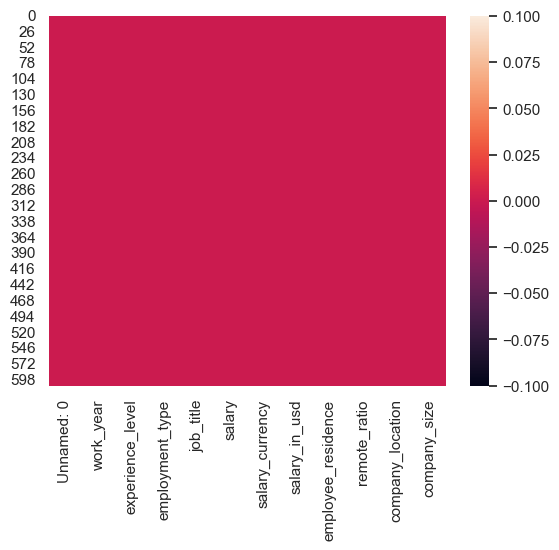

In [6]:
sns.heatmap(data.isnull()) # проверим датасет на наличие пропусков

В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов.

Кроме того удалим неинформативные признаки:
- **salary**, т.к. есть аналогичный поддающийся статистической обработке признак salary_in_usd. 
- **salary_currency**, т.к. используем для анализа значения зарплаты в долларах США. 
- **Unnamed: 0**, т.к. не имеет значения для статистического анализа.

In [7]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

data = data.drop(columns=['salary', 'salary_currency', 'Unnamed: 0'])
data.info()

print('Размер таблицы после удаления неинформативных признаков: {}'.format(data.shape))


Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB
Размер таблицы после удаления неинформативных признаков: (607, 9)


### Корреляционный анализ датасета с использованиеем тепловой карты корреляций признаков


<Axes: >

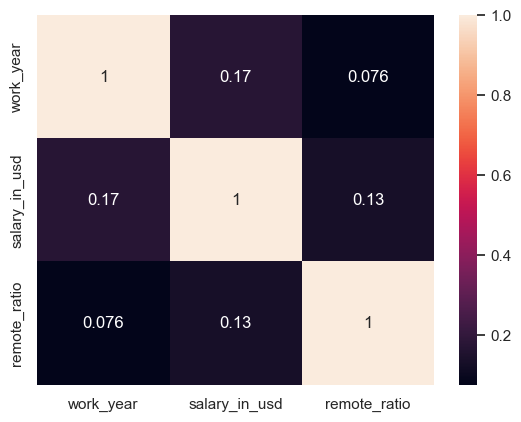

In [8]:
# используем числовые признаки, отображением коэффициентов
sns.heatmap(data.corr(numeric_only=True), annot=True)


В датасете среди числовых признаков - отсутствуют признаки, которые подлежали бы исключению из-за мультиколлениарности с другими признаками.


### Классификация признаков датасета на числовые и категориальные


**Категориальные признаки:**

***Категориальные порядковые признаки:***

*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями: 
    - EN (Entry-level/Junior), 
    - MI (Mid-level/Intermediate), 
    - SE (Senior-level/Expert), 
    - EX (Executive-level/Director);

***Категориальные номинальные признаки:***

*   *employment_type* — Тип трудоустройства для этой роли: 
    - PT (неполный рабочий день), 
    - FT (полный рабочий день), 
    - CT (контракт), 
    - FL (фриланс);
*   *job_title* — Роль, в которой соискатель работал в течение года;
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 - (удалённой работы нет (менее 20 %)), 
    - 50 - (частично удалённая работа), 
    - 100 - (полностью удалённая работа (более 80 %));
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   *company_size* — Среднее количество людей, работавших в компании в течение года: 
    - S - (менее 50 сотрудников (небольшая компания)), 
    - M - (от 50 до 250 сотрудников (средняя компания)), 
    - L - (более 250 сотрудников (крупная компания)).


**Числовые признаки:**
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com)




### Определение основных статистических характеристик для каждого из признаков

Для определения основных статистических характеристик для каждого из признаков датасета постоим отчет с использованием библиотеки d-tale

In [90]:
import dtale
d = dtale.show(data)
d

#### Основные статистические характеристики для категориальных признаков

In [10]:
# основные статистические характеристики для категориальных признаков
data_agg = data.describe(include=['object']).round(2)
display(data_agg)

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,280,588,143,332,355,326


#### Основные статистические характеристики для категориальных признаков, выраженных в виде числовых значений

In [11]:
# Для work_year
print('Распределение по годам:')
print(data['work_year'].value_counts())
print('\n')

# Для remote_ratio
print('Распределение по формату работы:')
print(data['remote_ratio'].value_counts())


Распределение по годам:
work_year
2022    318
2021    217
2020     72
Name: count, dtype: int64


Распределение по формату работы:
remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64


In [12]:
# С сортировкой и процентами
print('Распределение по годам:')
print(data['work_year'].value_counts(normalize=True).mul(100).round(2), '%')
print('\n')

print('Распределение по формату работы:')
print(data['remote_ratio'].value_counts(normalize=True).mul(100).round(2), '%')

Распределение по годам:
work_year
2022    52.39
2021    35.75
2020    11.86
Name: proportion, dtype: float64 %


Распределение по формату работы:
remote_ratio
100    62.77
0      20.92
50     16.31
Name: proportion, dtype: float64 %


Дополнительно построим гистограмму и боксплот для числового признака **salary_in_usd**

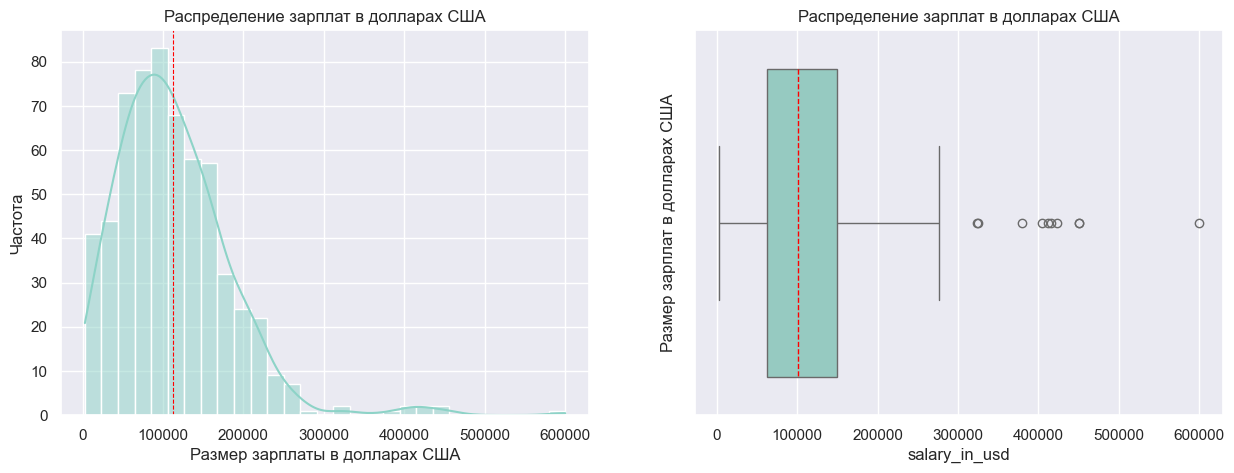

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплат в долларах США')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат в долларах США')
axes[1].set_title('Распределение зарплат в долларах США')

plt.show()

In [14]:
# основные статистические характеристики для числового признака salary_in_usd
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат в долларах США']
data_agg

,Размер зарплат в долларах США
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


### Выводы по разделу 1:
Распределение числового признака Зарплата в долларах США  **salary_in_usd**  отлично от нормального, имеются выбросы.

# <center> 2. Разведывательный анализ данных

## 2.1 Визуальный анализ данных

Выполняем визуальный анализ данных, для этого:

Сделаем базовый анализ для каждого признака, участвующего в исследовании:
- для числовых признаков построим гистограммы, иллюстрирующие распределения;
- для категориальных признаков определим количество записей для каждой категории и построим соответствующие визуализации.

2025-01-31 15:35:29,357 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-31 15:35:29,365 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Статистические характеристики для salary_in_usd:
count       607.00
mean     112297.87
std       70957.26
min        2859.00
25%       62726.00
50%      101570.00
75%      150000.00
max      600000.00
Name: salary_in_usd, dtype: float64

--------------------------------------------------



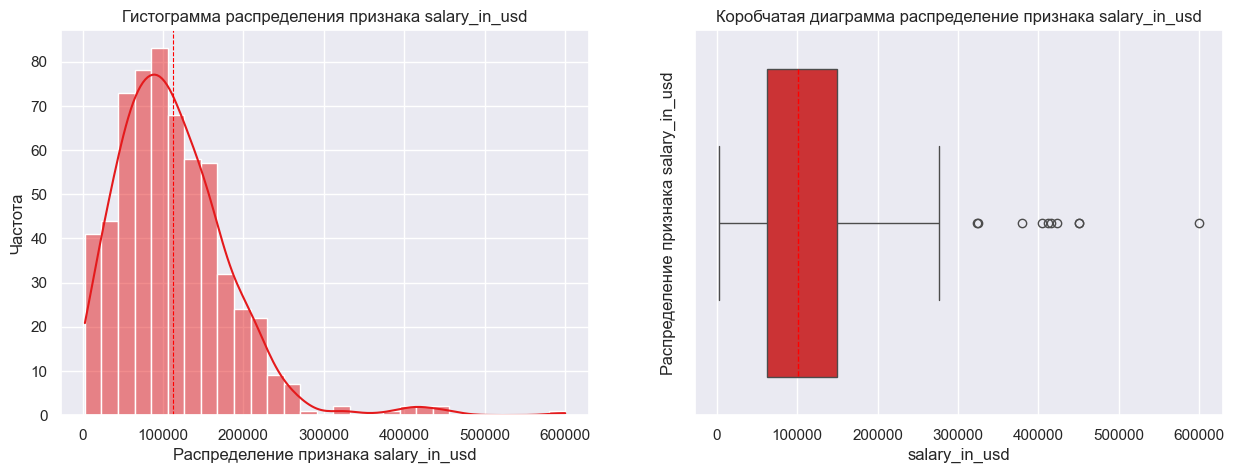

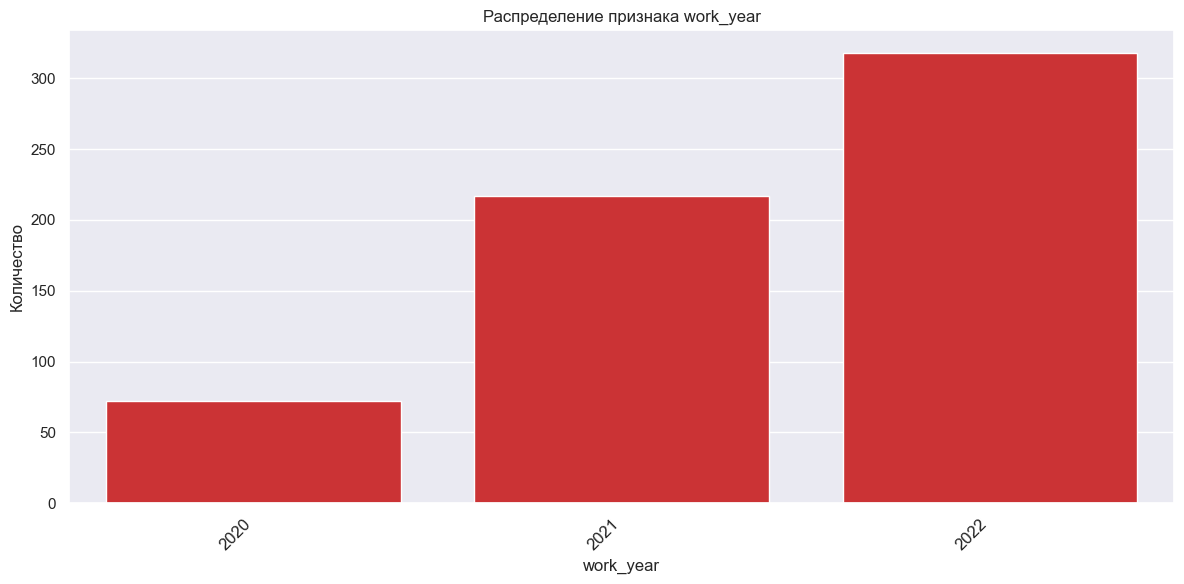


Процентное соотношение для work_year:
work_year
2022    52.39
2021    35.75
2020    11.86
Name: proportion, dtype: float64 %

--------------------------------------------------



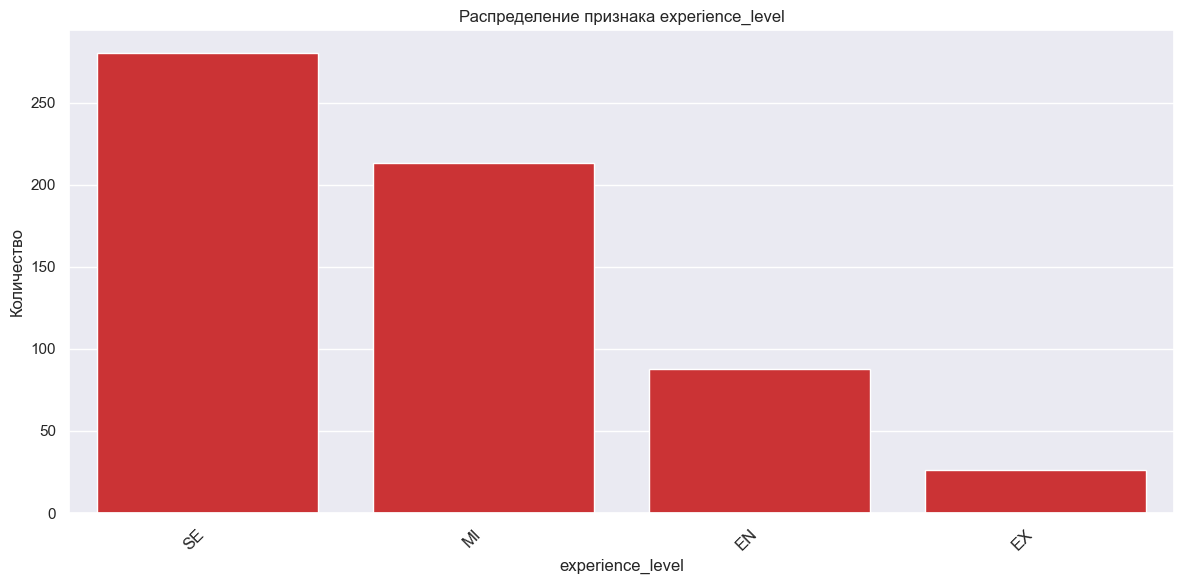


Процентное соотношение для experience_level:
experience_level
SE    46.13
MI    35.09
EN    14.50
EX     4.28
Name: proportion, dtype: float64 %

--------------------------------------------------



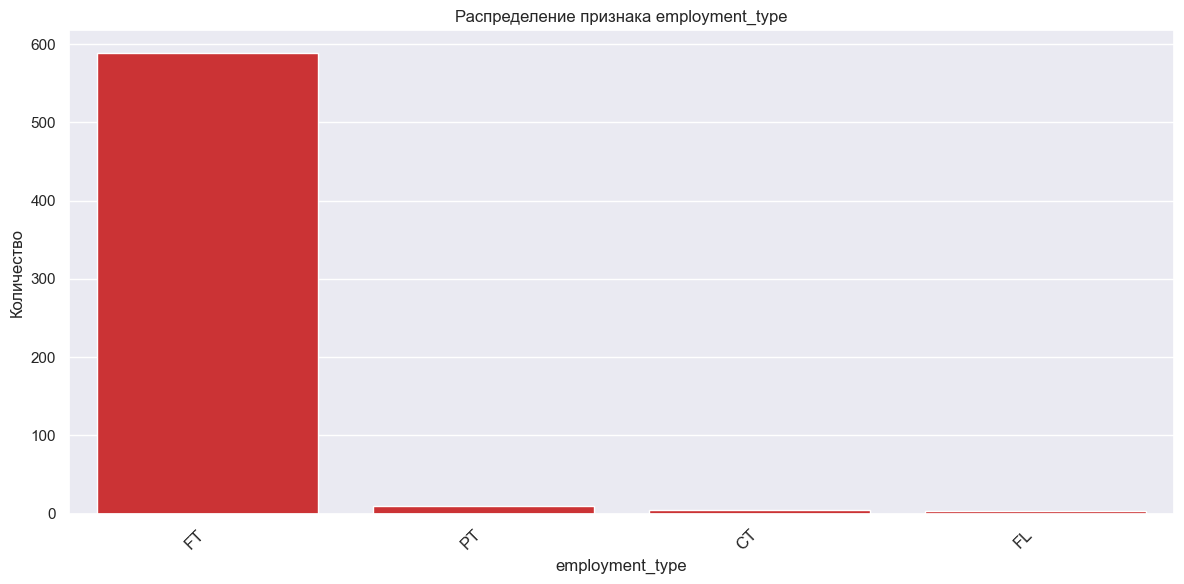


Процентное соотношение для employment_type:
employment_type
FT    96.87
PT     1.65
CT     0.82
FL     0.66
Name: proportion, dtype: float64 %

--------------------------------------------------



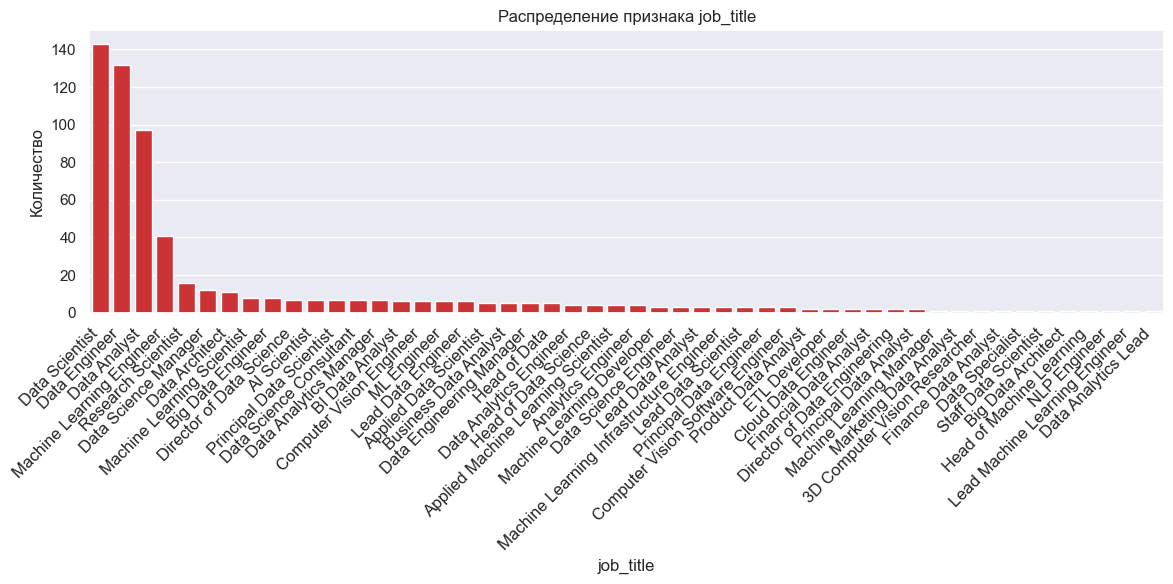


Процентное соотношение для job_title:
job_title
Data Scientist                              23.56
Data Engineer                               21.75
Data Analyst                                15.98
Machine Learning Engineer                    6.75
Research Scientist                           2.64
Data Science Manager                         1.98
Data Architect                               1.81
Machine Learning Scientist                   1.32
Big Data Engineer                            1.32
Director of Data Science                     1.15
AI Scientist                                 1.15
Principal Data Scientist                     1.15
Data Science Consultant                      1.15
Data Analytics Manager                       1.15
BI Data Analyst                              0.99
Computer Vision Engineer                     0.99
ML Engineer                                  0.99
Lead Data Engineer                           0.99
Applied Data Scientist                       0.82
B

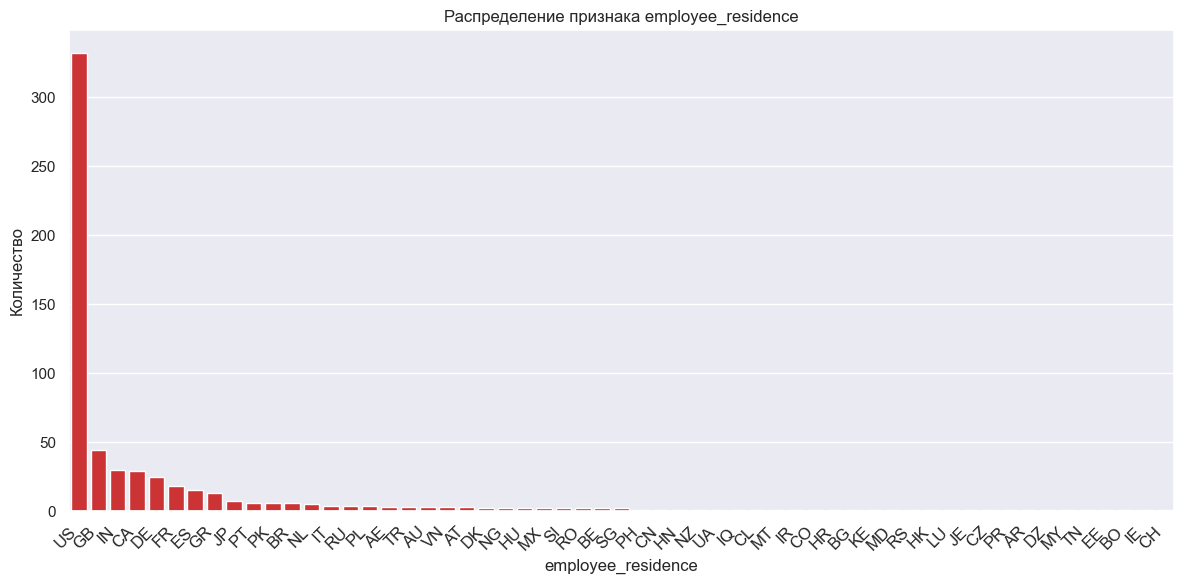

2025-01-31 15:35:30,703 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-31 15:35:30,709 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Процентное соотношение для employee_residence:
employee_residence
US    54.70
GB     7.25
IN     4.94
CA     4.78
DE     4.12
FR     2.97
ES     2.47
GR     2.14
JP     1.15
PT     0.99
PK     0.99
BR     0.99
NL     0.82
IT     0.66
RU     0.66
PL     0.66
AE     0.49
TR     0.49
AU     0.49
VN     0.49
AT     0.49
DK     0.33
NG     0.33
HU     0.33
MX     0.33
SI     0.33
RO     0.33
BE     0.33
SG     0.33
PH     0.16
CN     0.16
HN     0.16
NZ     0.16
UA     0.16
IQ     0.16
CL     0.16
MT     0.16
IR     0.16
CO     0.16
HR     0.16
BG     0.16
KE     0.16
MD     0.16
RS     0.16
HK     0.16
LU     0.16
JE     0.16
CZ     0.16
PR     0.16
AR     0.16
DZ     0.16
MY     0.16
TN     0.16
EE     0.16
BO     0.16
IE     0.16
CH     0.16
Name: proportion, dtype: float64 %

--------------------------------------------------



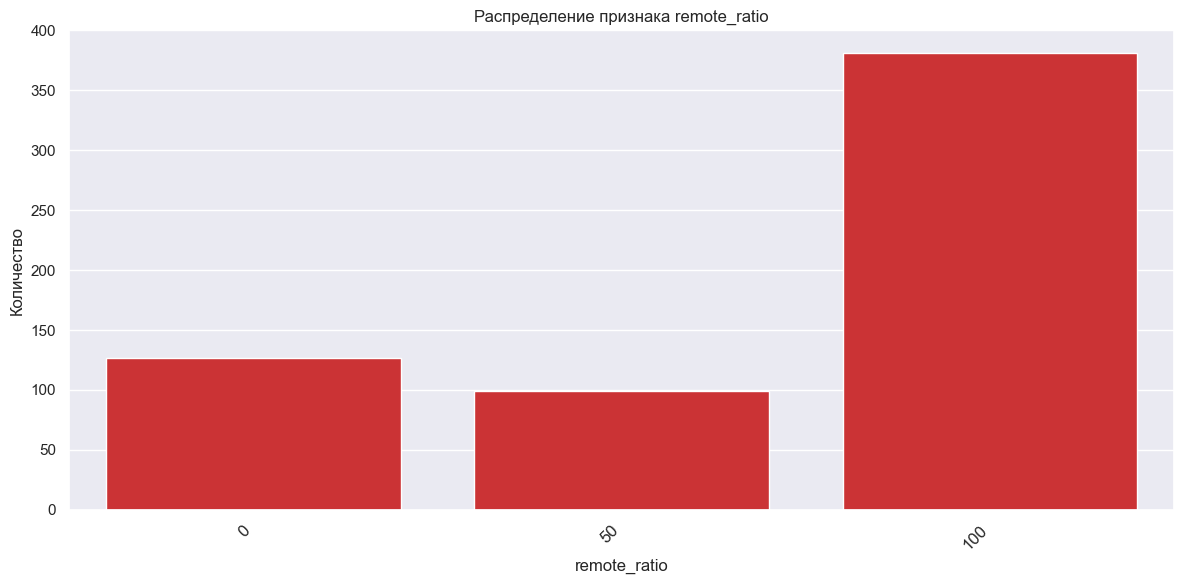


Процентное соотношение для remote_ratio:
remote_ratio
100    62.77
0      20.92
50     16.31
Name: proportion, dtype: float64 %

--------------------------------------------------



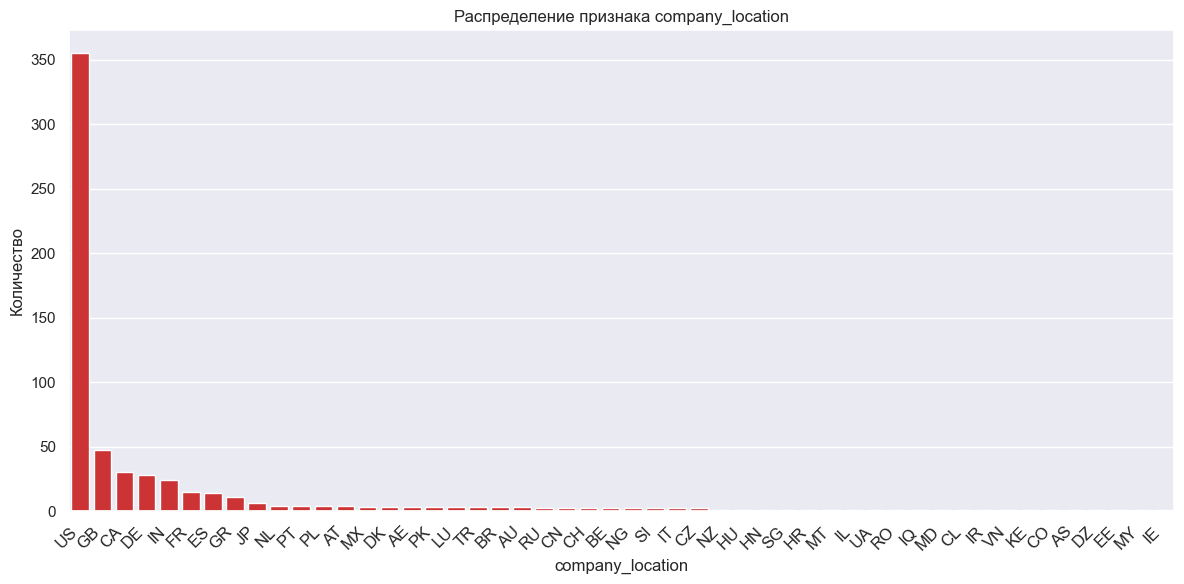


Процентное соотношение для company_location:
company_location
US    58.48
GB     7.74
CA     4.94
DE     4.61
IN     3.95
FR     2.47
ES     2.31
GR     1.81
JP     0.99
NL     0.66
PT     0.66
PL     0.66
AT     0.66
MX     0.49
DK     0.49
AE     0.49
PK     0.49
LU     0.49
TR     0.49
BR     0.49
AU     0.49
RU     0.33
CN     0.33
CH     0.33
BE     0.33
NG     0.33
SI     0.33
IT     0.33
CZ     0.33
NZ     0.16
HU     0.16
HN     0.16
SG     0.16
HR     0.16
MT     0.16
IL     0.16
UA     0.16
RO     0.16
IQ     0.16
MD     0.16
CL     0.16
IR     0.16
VN     0.16
KE     0.16
CO     0.16
AS     0.16
DZ     0.16
EE     0.16
MY     0.16
IE     0.16
Name: proportion, dtype: float64 %

--------------------------------------------------



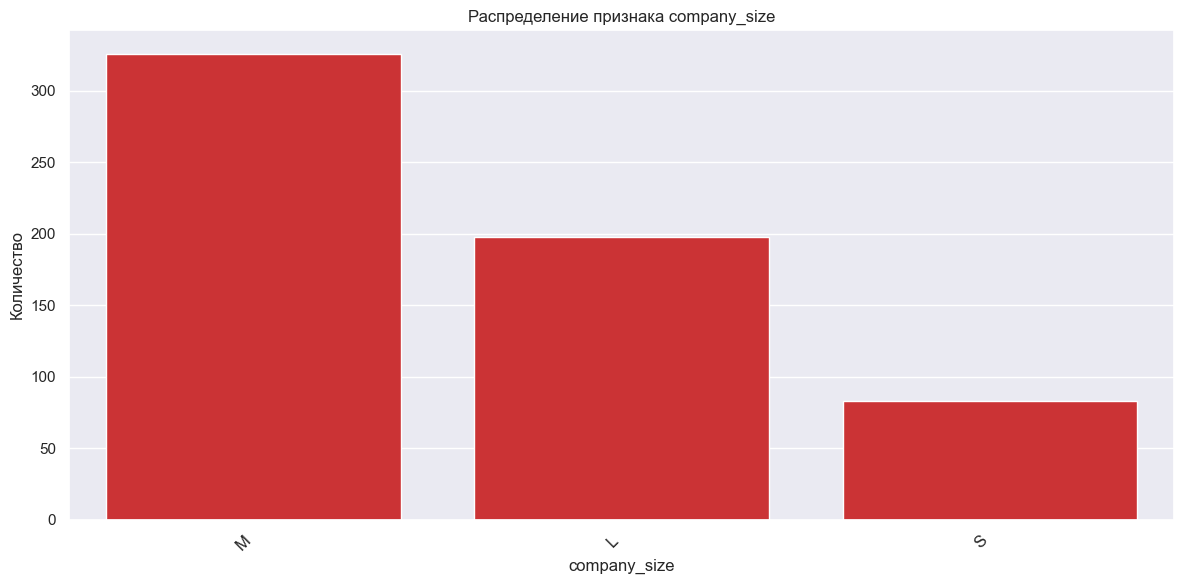


Процентное соотношение для company_size:
company_size
M    53.71
L    32.62
S    13.67
Name: proportion, dtype: float64 %

--------------------------------------------------



In [89]:
# Создаем списки числовых и категориальных признаков
numeric_features = ['salary_in_usd']
categorical_features = ['work_year', 'experience_level', 'employment_type', 
                       'job_title', 'employee_residence', 'remote_ratio',
                       'company_location', 'company_size']

# Создаем копию данных для безопасного преобразования
data_plot = data.copy()

# Преобразуем числовые категориальные признаки
data_plot['work_year'] = data_plot['work_year'].astype(int)
data_plot['remote_ratio'] = data_plot['remote_ratio'].astype(int)

# Анализ числовых признаков
for feature in numeric_features:
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(data[feature], kde=True, ax=axes[0])
    axes[0].set(xlabel=f'Распределение признака {feature}', ylabel='Частота')
    axes[0].set_title(f'Гистограмма распределения признака {feature}')
    axes[0].axvline(data[feature].mean(), color='red', linestyle='--', linewidth=0.8)

    sns.boxplot(data[feature], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
    axes[1].set(ylabel=f'Распределение признака {feature}')
    axes[1].set_title(f'Коробчатая диаграмма распределение признака {feature}')
    
    
    print(f'\nСтатистические характеристики для {feature}:')
    print(data_plot[feature].describe().round(2))
    print('\n' + '-'*50 + '\n')

# Анализ категориальных признаков
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    
    value_counts = data_plot[feature].value_counts()
    
    # Для числовых категориальных признаков сортируем значения
    if feature in ['work_year', 'remote_ratio']:
        value_counts = value_counts.sort_index()
    
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Распределение признака {feature}')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()
    
    print(f'\nПроцентное соотношение для {feature}:')
    print(data_plot[feature].value_counts(normalize=True).mul(100).round(2), '%')
    print('\n' + '-'*50 + '\n')

Распределение числового признака Зарплата в долларах США  **salary_in_usd**  отлично от нормального, имеются выбросы.

#### а) Визуализация влияния каждого из признаков на зарплату по всем наименованиям Data Scientist

2025-01-30 23:36:49,509 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-30 23:36:49,517 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


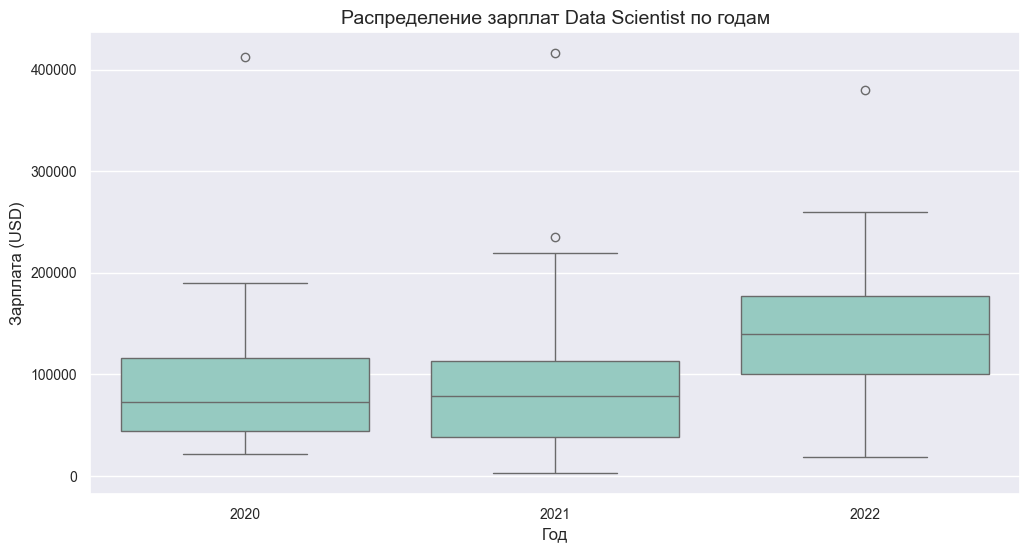

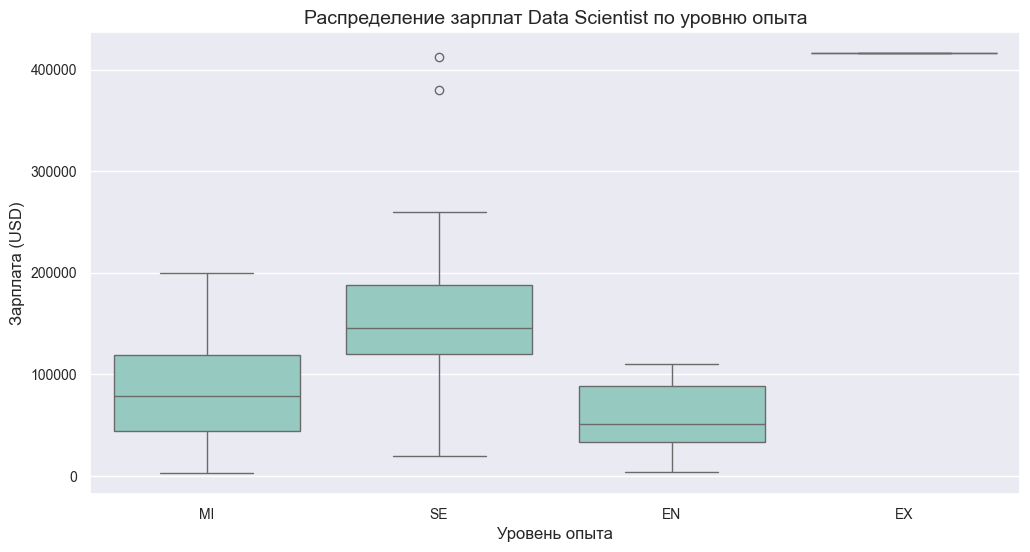

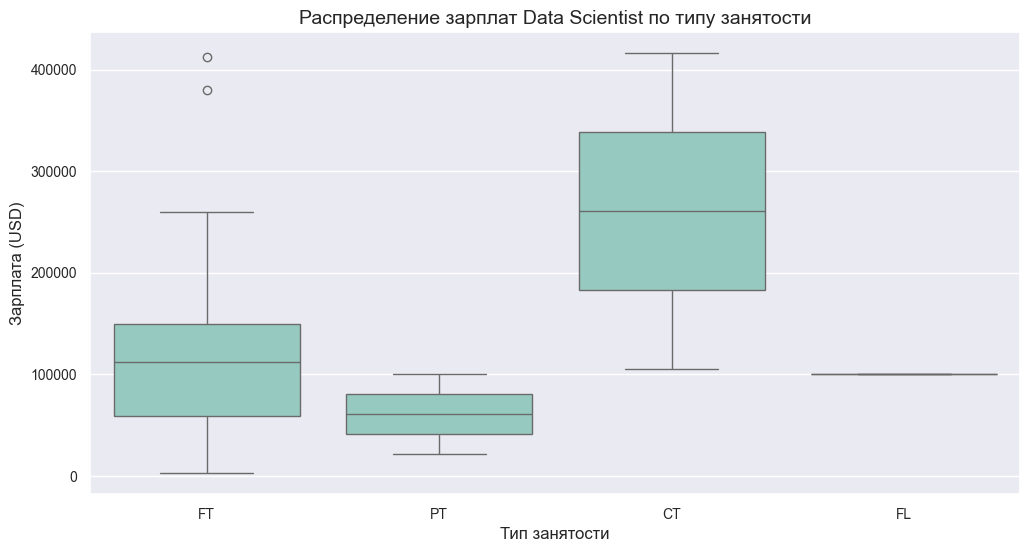

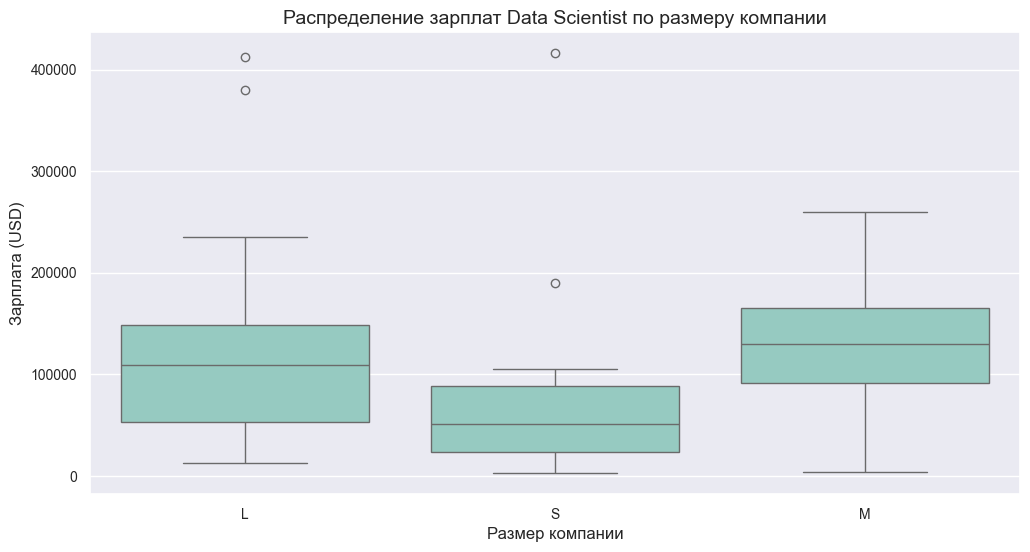

2025-01-30 23:36:50,088 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-30 23:36:50,095 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


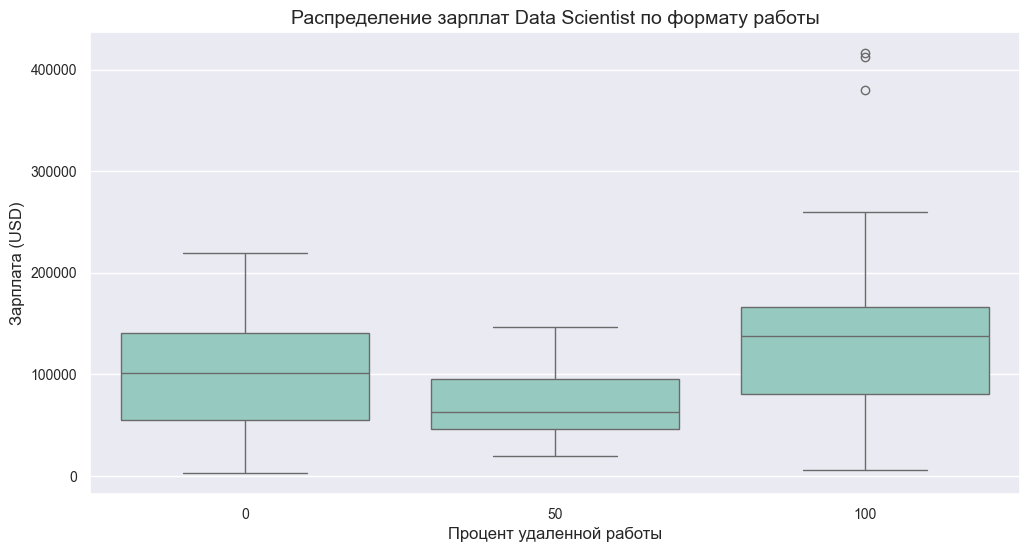

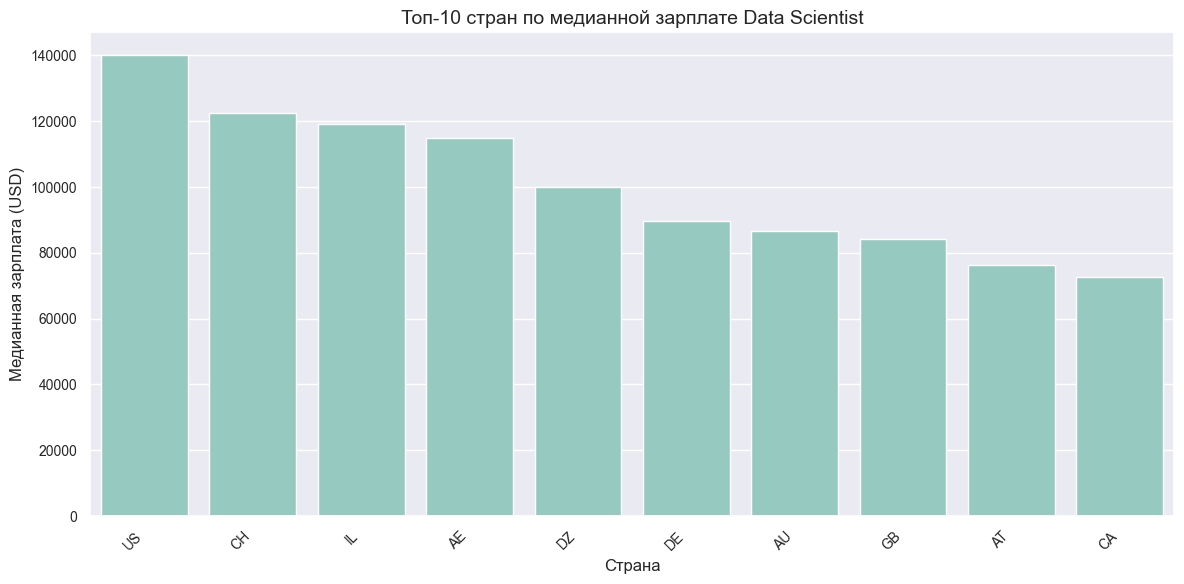

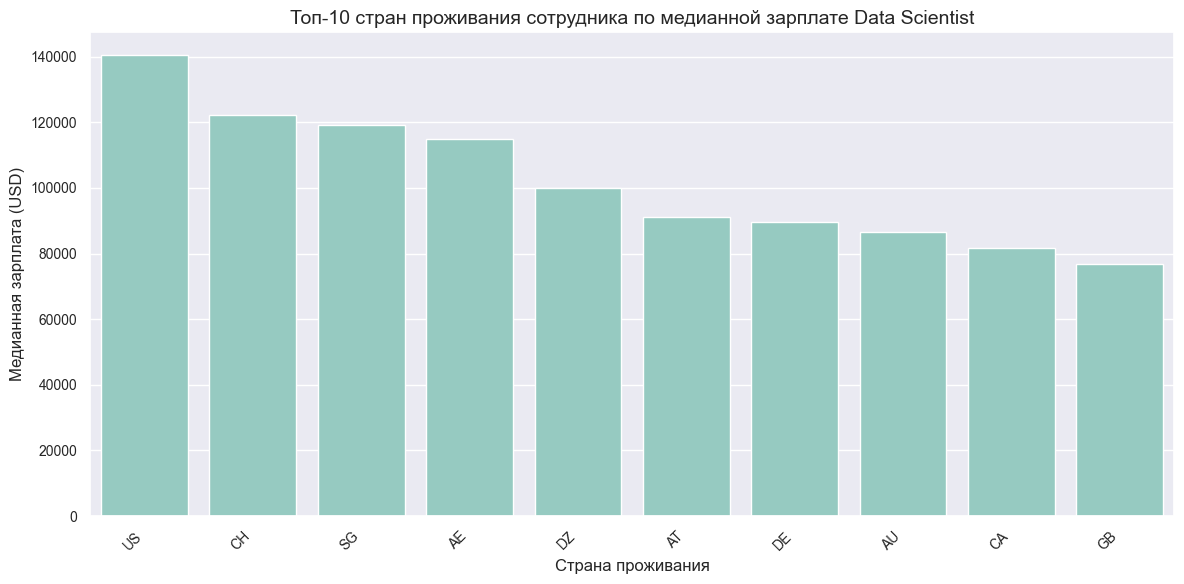


Основные статистики по зарплатам Data Scientist:
count       159.00
mean     115134.60
std       71391.53
min        2859.00
25%       59733.50
50%      109000.00
75%      150000.00
max      416000.00
Name: salary_in_usd, dtype: float64
Зарплаты Data Scientist по уровню опыта:
                  count       mean       std       min        25%       50%  \
experience_level                                                              
EN                 23.0   57709.43  32581.69    4000.0   33197.00   51321.0   
EX                  1.0  416000.00       NaN  416000.0  416000.00  416000.0   
MI                 64.0   84368.53  47391.56    2859.0   44869.25   78916.5   
SE                 71.0  157232.38  64105.21   20171.0  120080.00  146000.0   

                        75%       max  
experience_level                       
EN                 88351.50  110037.0  
EX                416000.00  416000.0  
MI                119294.25  200000.0  
SE                187550.00  412000.0  
Зарпла

In [16]:
# Создаем датафрейм только с Data Scientist
ds_data = data[data['job_title'].str.contains('Data Scientist', case=False)].copy()

# Настройка размера графиков и стиля
fig_size = (12, 6)
sns.set_theme("notebook") 
sns.set_palette("Set3") 
#sns.set_theme(style='notebook') 


# 1. Зарплата по годам
plt.figure(figsize=fig_size)
sns.boxplot(data=ds_data, x='work_year', y='salary_in_usd')
plt.title('Распределение зарплат Data Scientist по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 2. Зарплата по уровню опыта
plt.figure(figsize=fig_size)
sns.boxplot(data=ds_data, x='experience_level', y='salary_in_usd')
plt.title('Распределение зарплат Data Scientist по уровню опыта', fontsize=14)
plt.xlabel('Уровень опыта', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 3. Зарплата по типу занятости
plt.figure(figsize=fig_size)
sns.boxplot(data=ds_data, x='employment_type', y='salary_in_usd')
plt.title('Распределение зарплат Data Scientist по типу занятости', fontsize=14)
plt.xlabel('Тип занятости', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 4. Зарплата по размеру компании
plt.figure(figsize=fig_size)
sns.boxplot(data=ds_data, x='company_size', y='salary_in_usd')
plt.title('Распределение зарплат Data Scientist по размеру компании', fontsize=14)
plt.xlabel('Размер компании', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 5. Зарплата по формату работы
plt.figure(figsize=fig_size)
sns.boxplot(data=ds_data, x='remote_ratio', y='salary_in_usd')
plt.title('Распределение зарплат Data Scientist по формату работы', fontsize=14)
plt.xlabel('Процент удаленной работы', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 6. Топ-10 стран по медианной зарплате
top_10_countries = ds_data.groupby('company_location')['salary_in_usd'].median().nlargest(10)
plt.figure(figsize=fig_size)
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title('Топ-10 стран по медианной зарплате Data Scientist', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Медианная зарплата (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 7. Топ-10 стран проживания сотрудника по медианной зарплате
top_10_countries = ds_data.groupby('employee_residence')['salary_in_usd'].median().nlargest(10)
plt.figure(figsize=fig_size)
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title('Топ-10 стран проживания сотрудника по медианной зарплате Data Scientist', fontsize=14)
plt.xlabel('Страна проживания', fontsize=12)
plt.ylabel('Медианная зарплата (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# 7. Дополнительная статистика
print("\nОсновные статистики по зарплатам Data Scientist:")
print(ds_data['salary_in_usd'].describe().round(2))

data_agg = ds_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Scientist по уровню опыта:')
print(data_agg)

data_agg = ds_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Scientist по типу занятости:')
print(data_agg)


data_agg = ds_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Scientist по размеру компании:')
print(data_agg)

data_agg = ds_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Scientist по формату работы:')
print(data_agg)

data_agg = ds_data.groupby('company_location')['salary_in_usd'].describe()\
    .sort_values('mean', ascending=False)\
    .head(10)\
    .round(2)
print('Зарплаты Data Scientist по странам (10 наибольших):')
print(data_agg)

data_agg = ds_data.groupby('employee_residence')['salary_in_usd'].describe()\
    .sort_values('mean', ascending=False)\
    .head(10)\
    .round(2)
print('Зарплаты Data Scientist по странам проживания сотрудника (10 наибольших):')
print(data_agg)


#### Выводы по разделу 2.1 а:

Hа основе визуального анализа можно отметить факторы, которые влияют на заработную плату Data Scientist:
- год, в котором была выплачена зарплата;
- уровень опыта;
- тип занятости;
- размер компании;
- форма работы;
- страна, в которой работает компания.

Можно отметить, что для Data Scientist - показатель Заработная плата (USD) по году имеет тенденцию к уверенному увеличению средних и медианных значений за период с 2020 по 2022 гг. 
Кроме того, отмечается уменьшение количества выбросов, у увеличение межквартильного размаха IRQ.

По влиянию на зарплату Data Scientist уровня опыта можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с уровнем опыта EX (Executive-level/Director), при этом межквартильный размах IRQ в этой категории исчезающе мал, что позволят предположить, что этот уровень опыта представлен в датасете минимальным количеством наблюдений. При этом следующий по величине медианы уровень опыта SE (Senior-level/Expert;) имеет значительно больший IRQ, что позволяет предположить, что этот уровень опыта представлен в датасете большим количеством наблюдений.

По влиянию на зарплату Data Scientist типа занятости можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с типом занятости CT (контракт), при этом межквартильный размах IRQ в этой категории очень широкий. На втором месте по медианной зарплате стоит тип занятости FT (полный рабочий день), при этом межквартильный размах IRQ в этой категории также очень широкий. Кроме того, можно отметить, что тип занятости FL (фриланс) имеет очень узкий межквартильный размах IRQ в этой категории, что позволяет предположить, что этот тип занятости представлен в датасете минимальным количеством наблюдений.

По влиянию на зарплату Data Scientist размера компании можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с размером компании M (от 50 до 250 сотрудников (средняя компания)), при этом межквартильный размах IRQ в этой категории очень широкий.

По влиянию на зарплату Data Scientist форма работы можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с форматом работы 100 (полностью удалённая работа (более 80 %)), при этом межквартильный размах IRQ в этой категории также очень широкий.

По влиянию на зарплату Data Scientist страны можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов из страны US (США). На втором месте по медианной зарплате стоит страна CH (Швейцария).

По влиянию на зарплату Data Scientist страны проживания сотрудника можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов из страны US (США). На втором месте по медианной зарплате стоит страна CH (Швейцария).

Поскольку визуальный анализ не позволяет сделать однозначных выводов о статистической значимости различий, в следующем разделе будут проведены статистические тесты.

#### б) Визуализация влияния каждого из признаков на зарплату по всем наименованиям Data Engineer

2025-01-31 09:02:46,381 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-31 09:02:46,393 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


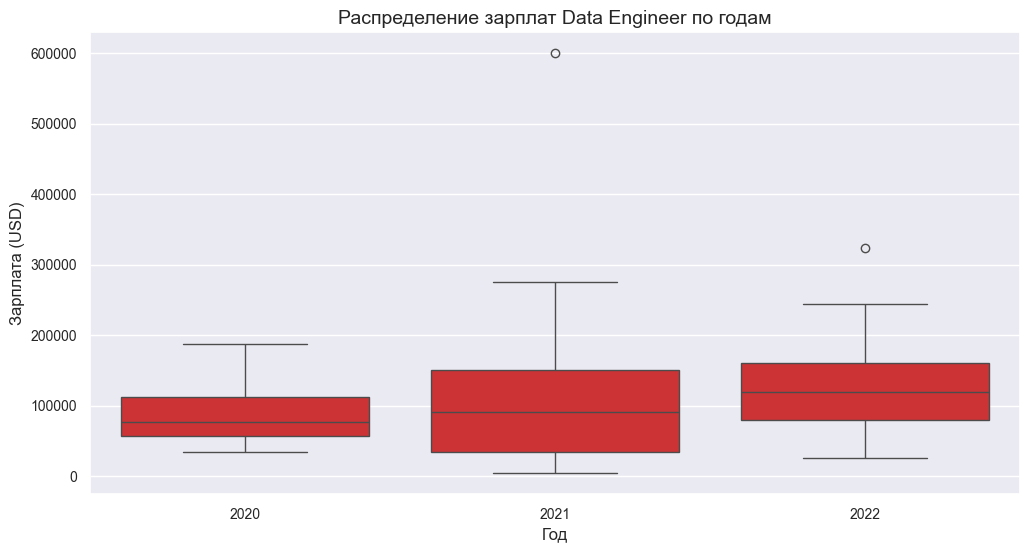

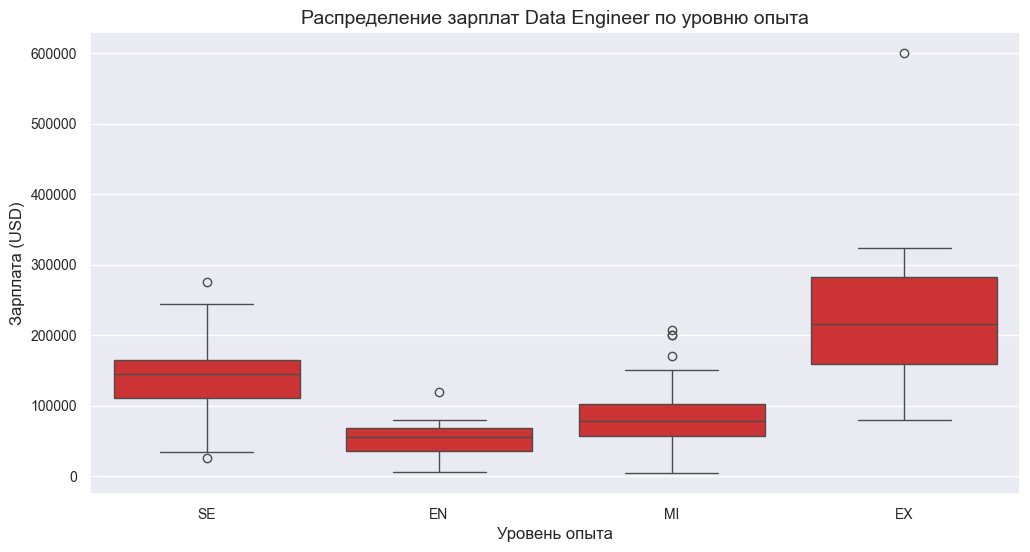

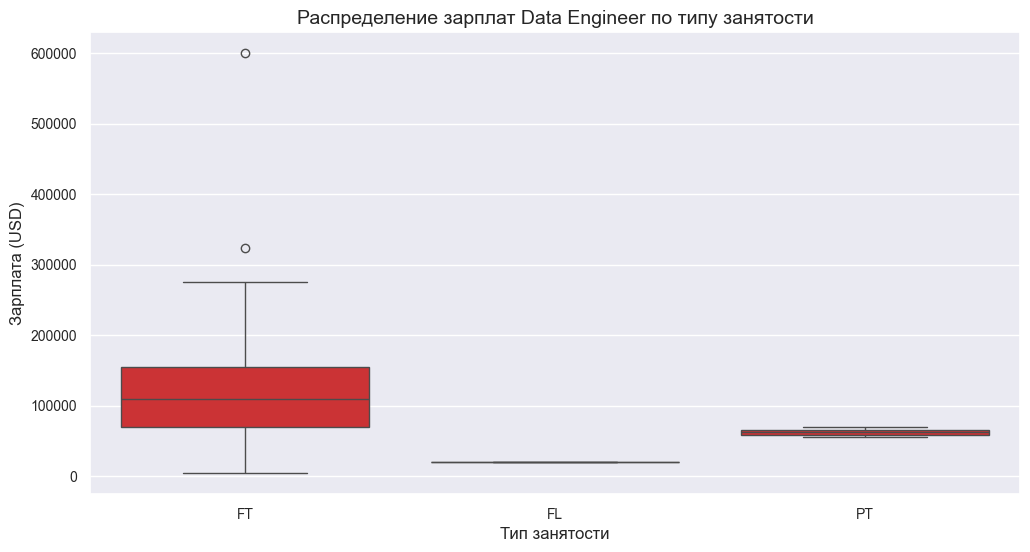

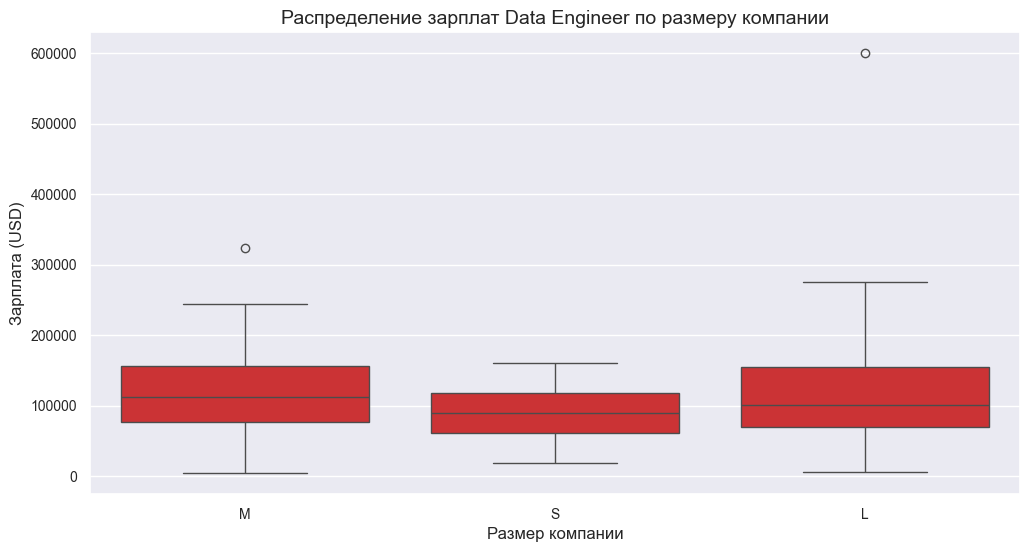

2025-01-31 09:02:46,912 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-31 09:02:46,918 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


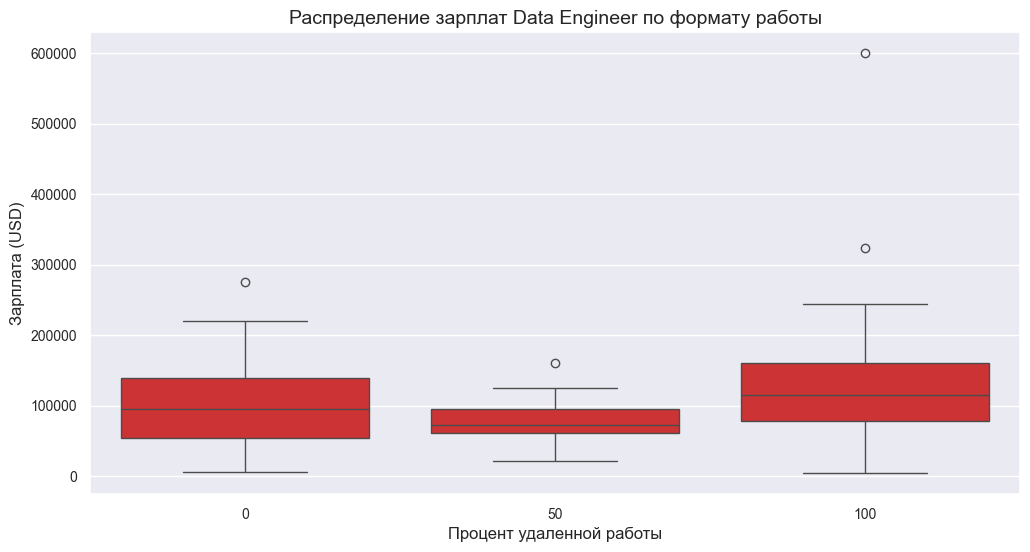

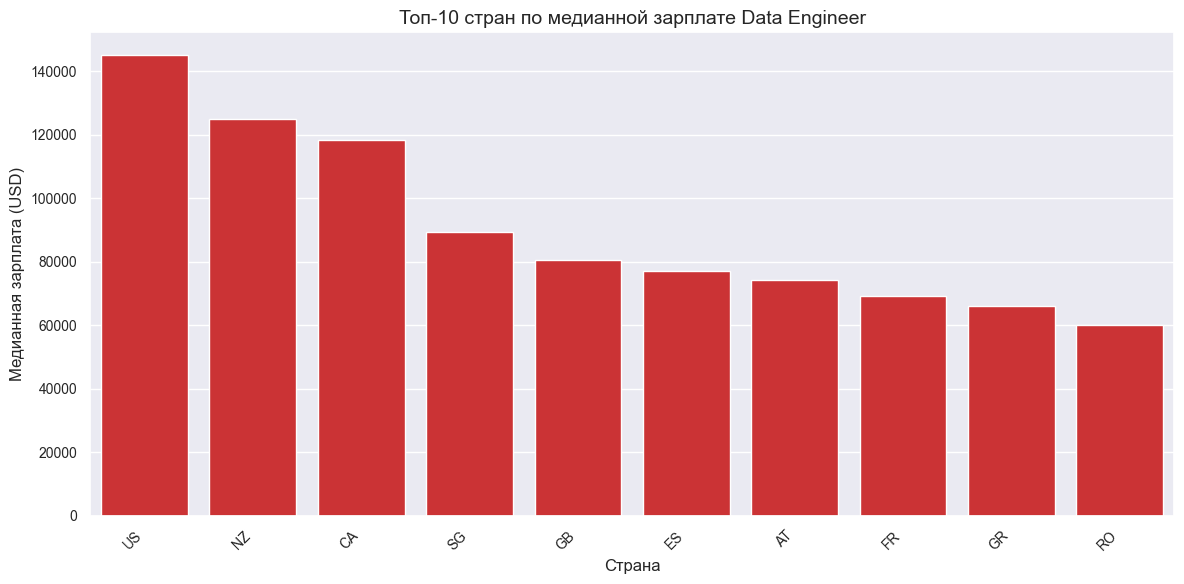

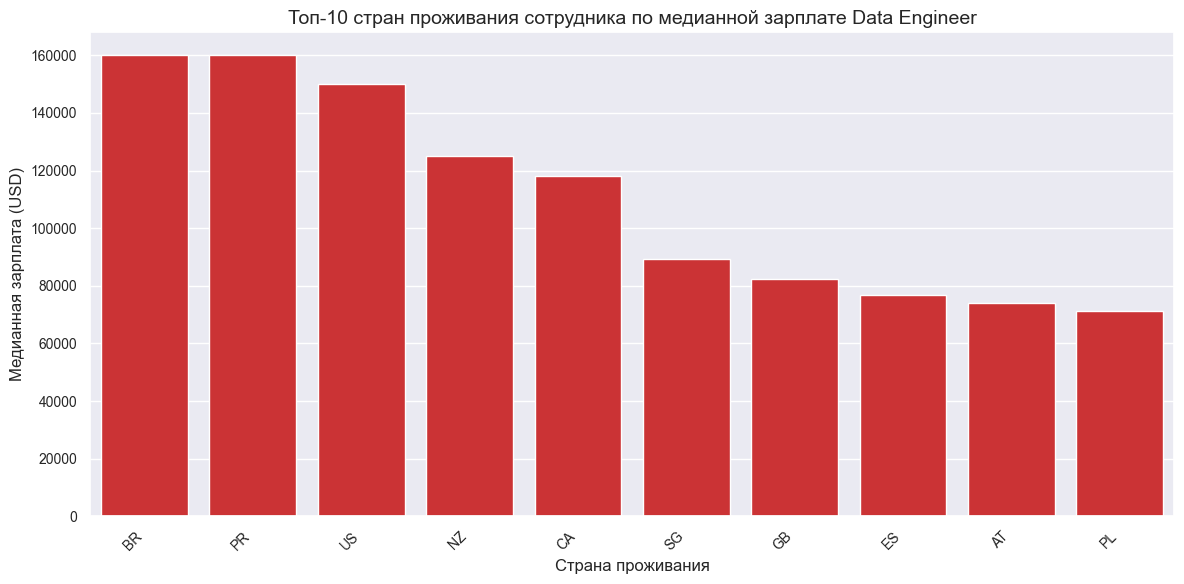


Основные статистики по зарплатам Data Engineer:
count       158.00
mean     115808.51
std       70474.68
min        4000.00
25%       69805.75
50%      108912.00
75%      154900.00
max      600000.00
Name: salary_in_usd, dtype: float64
Зарплаты Data Engineer по уровню опыта:
                  count       mean        std      min       25%       50%  \
experience_level                                                             
EN                 15.0   53287.47   28595.99   5882.0   36058.5   54742.0   
EX                  7.0  254288.57  172191.14  79833.0  159093.5  216000.0   
MI                 59.0   82414.37   44150.19   4000.0   57447.0   78526.0   
SE                 77.0  140986.56   47279.65  25000.0  110500.0  145000.0   

                       75%       max  
experience_level                      
EN                 67506.5  120000.0  
EX                283000.0  600000.0  
MI                102351.0  206699.0  
SE                165400.0  276000.0  
Зарплаты Data Engine

In [30]:
# Создаем датафрейм только с Data Engineer
de_data = data[data['job_title'].str.contains('Data Engineer', case=False)].copy()

# Настройка размера графиков и стиля
fig_size = (12, 6)
sns.set_theme("notebook") 
sns.set_palette("Set1") 
#sns.set_theme(style='notebook') 


# 1. Зарплата по годам
plt.figure(figsize=fig_size)
sns.boxplot(data=de_data, x='work_year', y='salary_in_usd')
plt.title('Распределение зарплат Data Engineer по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 2. Зарплата по уровню опыта
plt.figure(figsize=fig_size)
sns.boxplot(data=de_data, x='experience_level', y='salary_in_usd')
plt.title('Распределение зарплат Data Engineer по уровню опыта', fontsize=14)
plt.xlabel('Уровень опыта', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 3. Зарплата по типу занятости
plt.figure(figsize=fig_size)
sns.boxplot(data=de_data, x='employment_type', y='salary_in_usd')
plt.title('Распределение зарплат Data Engineer по типу занятости', fontsize=14)
plt.xlabel('Тип занятости', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 4. Зарплата по размеру компании
plt.figure(figsize=fig_size)
sns.boxplot(data=de_data, x='company_size', y='salary_in_usd')
plt.title('Распределение зарплат Data Engineer по размеру компании', fontsize=14)
plt.xlabel('Размер компании', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 5. Зарплата по формату работы
plt.figure(figsize=fig_size)
sns.boxplot(data=de_data, x='remote_ratio', y='salary_in_usd')
plt.title('Распределение зарплат Data Engineer по формату работы', fontsize=14)
plt.xlabel('Процент удаленной работы', fontsize=12)
plt.ylabel('Зарплата (USD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 6. Топ-10 стран по медианной зарплате
top_10_countries = de_data.groupby('company_location')['salary_in_usd'].median().nlargest(10)
plt.figure(figsize=fig_size)
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title('Топ-10 стран по медианной зарплате Data Engineer', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Медианная зарплата (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 6. Топ-10 стран проживания сотрудника по медианной зарплате
top_10_countries = de_data.groupby('employee_residence')['salary_in_usd'].median().nlargest(10)
plt.figure(figsize=fig_size)
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title('Топ-10 стран проживания сотрудника по медианной зарплате Data Engineer', fontsize=14)
plt.xlabel('Страна проживания', fontsize=12)
plt.ylabel('Медианная зарплата (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# 7. Дополнительная статистика
print("\nОсновные статистики по зарплатам Data Engineer:")
print(de_data['salary_in_usd'].describe().round(2))

data_agg = de_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Engineer по уровню опыта:')
print(data_agg)

data_agg = de_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Engineer по типу занятости:')
print(data_agg)


data_agg = de_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Engineer по размеру компании:')
print(data_agg)

data_agg = de_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплаты Data Engineer по формату работы:')
print(data_agg)

data_agg = de_data.groupby('company_location')['salary_in_usd'].describe()\
    .sort_values('mean', ascending=False)\
    .head(10)\
    .round(2)
print('Зарплаты Data Engineer по странам (10 наибольших):')
print(data_agg)

data_agg = de_data.groupby('employee_residence')['salary_in_usd'].describe()\
    .sort_values('mean', ascending=False)\
    .head(10)\
    .round(2)
print('Зарплаты Data Engineer по странам проживания сотрудника (10 наибольших):')
print(data_agg)



#### Выводы по разделу 2.1 б:

Hа основе визуального анализа можно отметить факторы, которые влияют на заработную плату Data Engineer:
- год, в котором была выплачена зарплата;
- уровень опыта;
- тип занятости;
- размер компании;
- форма работы;
- страна, в которой работает компания.

Можно отметить, что для Data Engineer - показатель Заработная плата (USD) по году имеет тенденцию к небольшому увеличению средних и медианных значений за период с 2020 по 2022 гг. В 2021 году отмечается более широкий межквартильный размах IRQ и наличие выбросов.

По влиянию на зарплату Data Engineer уровня опыта можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с уровнем опыта EX (Executive-level/Director), при этом межквартильный размах IRQ в этой категории самый широкий, что этот уровень опыта представлен в датасете большим количеством наблюдений. При этом следующий по величине медианы уровень опыта SE (Senior-level/Expert;) имеет больший узкий IRQ, что позволяет предположить, что этот уровень опыта предполагает стадартизацию квалификационных требований к компетенций соискателей.

По влиянию на зарплату Data Engineer типа занятости можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с типом занятости FT (полный рабочий день), при этом межквартильный размах IRQ в этой категории очень широкий. 
Тип занятости CT (контракт) для Data Engineer в датасете отсутствуют наблюдения. Для типа занятости PT (неполный рабочий день) наблюдается существенное сжатие IRQ, что позволяет предположить, что этот тип занятости представлены в датасете небольшим количеством наблюдений. Кроме того, можно отметить, что тип занятости FL (фриланс) имеет очень узкий межквартильный размах IRQ в этой категории, что позволяет предположить, что этот тип занятости представлен в датасете минимальным количеством наблюдений.

По влиянию на зарплату Data Engineer размера компании можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с размером компании M (от 50 до 250 сотрудников (средняя компания)). Для размера компании S (от 10 до 50 сотрудников (маленькая компания)) наблюдается существенное сжатие IRQ, что позволяет предположить, что этот размер компании представлен в датасете меньшим количеством наблюдений. Для размера компании L (от 250 до 1000 сотрудников (большая компания)) наблюдается существенное увеличение IRQ, что позволяет предположить, что этот размер компании представлен в датасете большим количеством наблюдений и большим разбросом значений зарплаты.

По влиянию на зарплату Data Engineer форма работы можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов с форматом работы 100 (полностью удалённая работа (более 80 %)), при этом межквартильный размах IRQ в этой категории также очень широкий.

По влиянию на зарплату Data Engineer страны можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов из страны US (США). На втором месте по медианной зарплате стоит страна NZ (Новая Зеландия), на третьем месте стоит страна CA (Канада).

По влиянию на зарплату Data Engineer страны проживания сотрудника можно отметить, что наибольшие медианные значения зарплаты наблюдаются у специалистов из страны BR (Бразилия). На втором месте по медианной зарплате стоит страна PR (Пуэрто-Рико, Неинкорпорированная территория США), на третьем месте стоит страна US (США). 

Поскольку визуальный анализ не позволяет сделать однозначных выводов о статистической значимости различий, в следующем разделе будут проведены статистические тесты.

## 2.2. Статистический анализ данных

Решаем задачу нахождения ответов на ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Кроме того, в процессе анализа находим в данных другие интересные закономерности.

In [18]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

***

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 
Формулируем гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [20]:
# проводим тест Шапиро — Уилка 
def test_shapiro(df):
    _, p = stats.shapiro(df)
    print('p-value = %.3f' % (p))
    # интерпретируем результат
    if p <= alpha:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')



# Создаем датафрейм только с Data Scientist
ds_data = data[data['job_title'].str.contains('Data Scientist', case=False)].copy()

ds_2020 = ds_data[ds_data['work_year'] == 2020]['salary_in_usd']
ds_2021 = ds_data[ds_data['work_year'] == 2021]['salary_in_usd']
ds_2022 = ds_data[ds_data['work_year'] == 2022]['salary_in_usd']


_, p = stats.shapiro(ds_2020)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2020 году:')
decision_normality(p)

_, p = stats.shapiro(ds_2021)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2021 году:')
decision_normality(p)

_, p = stats.shapiro(ds_2022)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2022 году:')
decision_normality(p)




Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2020 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2021 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd в 2022 году:
p-value = 0.015
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



Поставленная задача - определить: наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2020 г. ($m_1$) больше или равен размеру зарплат у специалистов Data Scientist в 2021 г. ($m_2$) и размер зарплат у специалистов Data Scientist в 2021 г. ($m_2$) больше или равен размеру зарплат у специалистов Data Scientist в 2022 г. ($m_3$)

$$ H_0 : m_1 \geq m_2     \lor      m_2 \geq m_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2020 г. ($m_1$) меньше размера зарплат у специалистов Data Scientist в 2021 г. ($m_2$) и размер зарплат у специалистов Data Scientist в 2021 г. ($m_2$) меньше размера зарплат у специалистов Data Scientist в 2022 г. ($m_3$)

$$ H_1 : m_1 < m_2     \land     m_2 < m_3$$

Размер зарплат у специалистов Data Scientist — это количественный признак.

Групп три, они независимы. 

Признак не распределён по нормальному закону. 

В этом случае можно использовать U-критерий Манна — Уитни, сравнивая последовательно значения признака зарплат у специалистов Data Scientist по годам.

In [25]:
# проводим тест  U-критерий Манна — Уитни
_, p = stats.mannwhitneyu(ds_2020, ds_2021, alternative = 'less')
print('Проверяем часть нулевой гипотезы m1 >= m2:')
decision_hypothesis(p)


Проверяем часть нулевой гипотезы m1 >= m2:
p-value = 0.660
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Дополнительно проверим часть нулевой гипотезы m1 = m2:

In [29]:
# проводим тест  U-критерий Манна — Уитни
_, p = stats.mannwhitneyu(ds_2020, ds_2021)
print('Проверяем часть нулевой гипотезы m1 = m2:')
decision_hypothesis(p)

Проверяем часть нулевой гипотезы m1 = m2:
p-value = 0.689
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [26]:
# проводим тест  U-критерий Манна — Уитни
_, p = stats.mannwhitneyu(ds_2021, ds_2022, alternative = 'less')
print('Проверяем часть нулевой гипотезы m2 >= m3:')
decision_hypothesis(p)


Проверяем часть нулевой гипотезы m2 >= m3:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Таким образом, в результате анализа получен результат:

$$ m_1 = m_2     \land     m_2 < m_3$$

Соответветственно, отсутстввуют основания отвергнуть *Нулевую гипотезу* ($H_0$).
$$ H_0 : m_1 \geq m_2     \lor      m_2 \geq m_3$$

Дополнительно проверим соотношение $  m_1 < m_3 $ :

In [32]:
# проводим тест
_, p = stats.mannwhitneyu(ds_2020, ds_2022, alternative = 'less')
print('Проверяем дополнительную часть нулевой гипотезы m1 >= m3:')
decision_hypothesis(p)


Проверяем дополнительную часть нулевой гипотезы m1 >= m3:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Выводы по первому вопросу:

В результате статистического анализа подтверждаем нулевую гипотезу:
$$ H_0 : m_1 \geq m_2     \lor      m_2 \geq m_3$$

Т.е. можно утверждать, что **НЕ наблюдается ежегодный рост зарплат у специалистов Data Scientist**.

При этом подтверждаем дополнительную альтернативную гипотезу:

$$ H_{1 доп} : m_1 < m_3 $$

*Результат дополнительного исследования подтверждает, что наблюдается рост зарплат у специалистов Data Scientist в 2022 году по сравнению с 2020 годом (без учета значений 2021 года, когда ежегодный рост зарплат не наблюдается).*


***


### Проверка соотношения зарплат Data Scientist и Data Engineer в 2022 году


In [31]:
# Создаем датафрейм только с Data Scientist для 2022 года
ds_data = data[data['job_title'].str.contains('Data Scientist', case=False)].copy()
ds_2022 = ds_data[ds_data['work_year'] == 2022]['salary_in_usd']

# Создаем датафрейм только с Data Engineer для 2022 года
de_data = data[data['job_title'].str.contains('Data Engineer', case=False)].copy()
de_2022 = de_data[de_data['work_year'] == 2022]['salary_in_usd']


_, p = stats.shapiro(ds_2022)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist в 2022 году:')
decision_normality(p)

_, p = stats.shapiro(de_2022)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в 2022 году:')
decision_normality(p)

Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist в 2022 году:
p-value = 0.015
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в 2022 году:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Размер зарплат у специалистов Data Scientist и Data Engineer — это количественные признаки.

Групп две, они независимы. 

Признаки не распределёны по нормальному закону. 

В этом случае также можно использовать U-критерий Манна — Уитни.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2022 г. ($m_1$)  меньше или равен размеру зарплат у специалистов Data Engineer в 2022 г. ($m_2$)

$$ H_0 : m_1 \leq m_2     $$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2022 г. ($m_1$) больше размера зарплат у специалистов Data Engineer в 2022 г. ($m_2$)

$$ H_1 : m_1 > m_2     $$

In [39]:
# проводим тест
_, p = stats.mannwhitneyu(ds_2022, de_2022, alternative = 'greater')
print('Проверяем нулевую гипотезы m1 <= m2:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m1 <= m2:
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Дополнительно проверим двустороннюю нулевую гипотезу
$$ H_0 : m_1 = m_2     $$
и альтернативную ей
$$ H_0 : m_1 \neq m_2     $$

In [40]:
# проводим тест
_, p = stats.mannwhitneyu(ds_2022, de_2022)
print('Проверяем нулевую гипотезы m1 = m2:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m1 = m2:
p-value = 0.076
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Разница в p-значениях объясняется различием в гипотезах, которые мы проверяем с помощью критерия Манна-Уитни.

При использовании alternative='greater' мы проверяем одностороннюю гипотезу, что распределение зарплат Data Scientist в 2022 году (ds_2022) сдвинуто вправо по сравнению с распределением зарплат Data Engineer в 2022 году (de_2022).
Полученное p-значение = 0.038 указывает на то, что есть статистически значимые доказательства в пользу того, что зарплаты Data Scientist в 2022 году выше, чем зарплаты Data Engineer в 2022 году.

При использовании двустороннего теста (по умолчанию) мы проверяем гипотезу о том, что распределения зарплат Data Scientist и Data Engineer в 2022 году различаются, без указания направления (больше или меньше). Полученное p-значение = 0.076 указывает на то, что нет статистически значимых доказательств для утверждения, что распределения зарплат различаются.

Односторонний тест более чувствителен к направленным различиям и может выявить значимость там, где двусторонний тест этого не делает. Это объясняет, почему p-значение в одностороннем тесте меньше и указывает на значимость, в то время как в двустороннем тесте оно больше и не указывает на значимость.

**Таким образом подтверждаем *Альтернативную гипотезу* ($H_1$): размер зарплат у специалистов Data Scientist в 2022 г. ($m_1$) больше размера зарплат у специалистов Data Engineer в 2022 г. ($m_2$)**


***

### Проверка соотношения зарплат специалистов Data Scientist в компаниях различных размеров

In [41]:
# Создаем датафрейм только с Data Scientist для компаний разных размеров

ds_s = ds_data[ds_data['company_size'] == 'S']['salary_in_usd']
ds_m = ds_data[ds_data['company_size'] == 'M']['salary_in_usd']
ds_l = ds_data[ds_data['company_size'] == 'L']['salary_in_usd']


_, p = stats.shapiro(ds_s)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist в company_size S:')
decision_normality(p)

_, p = stats.shapiro(ds_m)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в в company_size M:')
decision_normality(p)

_, p = stats.shapiro(ds_l)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в в company_size L:')
decision_normality(p)

Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist в company_size S:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в в company_size M:
p-value = 0.722
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Engineer в в company_size L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Размер зарплат у специалистов Data Scientist — это количественный признак.

Групп три, они независимы. 

Признак не распределён по нормальному закону в двух группах из трёх.

В этом случае можно использовать Критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах).

**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза: медианы зарплат специалистов Data Scientist в компаниях размера S ($m_1$), размера M ($m_2$) и размера L ($m_3$) равны.

$$ H_0: m_1 = m_2 = m_3 $$


Альтернативная гипотеза: медианы зарплат специалистов Data Scientist в компаниях размера S ($m_1$), размера M ($m_2$) и размера L ($m_3$)  не равны.

$$ H_1: m_1 \neq m_2 \neq m_3 $$

In [42]:
_, p = stats.kruskal(ds_s, ds_m, ds_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Подтверждаем Альтернативную гипотезу: медианы зарплат специалистов Data Scientist в компаниях размера S ($m_1$), размера M ($m_2$) и размера L ($m_3$)  не равны.**

Проведем дополнительное исследование и сравним медианы зарплат специалистов Data Scientist в компаниях разных размеров попарно, используя U-критерий Манна — Уитни.

**Сформулируем дополнительные нулевую и альтернативные гипотезы**

Нулевая гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера S ($m_1$) больше или равна медиане зарплат специалистов Data Scientist в компаниях размера M ($m_2$).

$$ H_0: m_1 \geq m_2 $$


Альтернативная гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера S ($m_1$) меньше медианы зарплат специалистов Data Scientist в компаниях размера M ($m_2$)

$$ H_1: m_1 < m_2  $$

In [44]:
# проводим тест
_, p = stats.mannwhitneyu(ds_s, ds_m, alternative = 'less')
print('Проверяем нулевую гипотезы m1 >= m2:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m1 >= m2:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Нулевая гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера S ($m_1$) больше или равна медиане зарплат специалистов Data Scientist в компаниях размера L ($m_3$).

$$ H_0: m_1 \geq m_3 $$


Альтернативная гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера S ($m_1$) меньше медианы зарплат специалистов Data Scientist в компаниях размера L ($m_3$)

$$ H_1: m_1 < m_3  $$

In [45]:
# проводим тест
_, p = stats.mannwhitneyu(ds_s, ds_l, alternative = 'less')
print('Проверяем нулевую гипотезы m1 >= m3:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m1 >= m3:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Нулевая гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера M ($m_2$) больше или равна медиане зарплат специалистов Data Scientist в компаниях размера L ($m_3$).

$$ H_0: m_2 \geq m_3 $$


Альтернативная гипотеза: медиана зарплат специалистов Data Scientist в компаниях размера M ($m_2$) меньше медианы зарплат специалистов Data Scientist в компаниях размера L ($m_3$)

$$ H_1: m_2 < m_3  $$

In [47]:
# проводим тест
_, p = stats.mannwhitneyu(ds_m, ds_l, alternative = 'less')
print('Проверяем нулевую гипотезы m2 >= m3:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m2 >= m3:
p-value = 0.973
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Таким образом, по результатам тестов получаем результат:

$$ H_1: m_1 < m_2  $$

$$ H_1: m_1 < m_3  $$

$$ H_0: m_2 \geq m_3 $$

**По результатам сравнения можно сделать вывод**: 

Зарплаты специалистов Data Scientist в компаниях размера M больше, чем в компаниях размера S и размера L. 
Зарплаты специалистов Data Scientist в компаниях размера S меньше, чем в компаниях размера M и размера L.
Зарплаты специалистов Data Scientist в компаниях размера L меньше, чем в компаниях размера M и больше, чем в в компаниях размера S.

***

### Проверяем связь между наличием должностей Data Scientist и Data Engineer и размером компании

Нулевая гипотеза (H0): 

Нет связи между наличием должностей (Data Scientist/Data Engineer) и размером компании (S/M/L).

Альтернативная гипотеза (H1): 

Существует связь между наличием должностей (Data Scientist/Data Engineer) и размером компании (S/M/L).


Мы анализируем взаимосвязь между двумя категориальными признаками объектов одной выборки.

Предварительно проверим условие применимости критерия хи-квадрат ($\chi^2$)— наличие как минимум пяти объектов в каждой ячейке таблицы сопряжённости. 
При невыполнении условия применимости - используем в расчетах точный критерий Фишера.


In [58]:
from scipy.stats import fisher_exact

def get_job_type(job_title):
    job_title = job_title.lower()  # преобразуем в нижний регистр
    if 'data scientist' in job_title:
        return 'Data Scientist'
    elif 'data engineer' in job_title:
        return 'Data Engineer'
    else:
        return 'Other'


ds_de_data = data.copy()

# Добавляем новый столбец с типом должности
ds_de_data['job_type'] = ds_de_data['job_title'].apply(get_job_type)

# Создаем таблицу сопряженности
contingency_table = pd.crosstab(ds_de_data['job_type'], ds_de_data['company_size'])
print("Таблица сопряженности:")
print(contingency_table)
print("\n")

# Проверяем, есть ли ячейки с количеством наблюдений менее 5
min_count = contingency_table.min().min()
cells_less_than_5 = (contingency_table < 5).sum().sum()

print(f"Минимальное количество наблюдений в ячейке: {min_count}")
print(f"Количество ячеек с числом наблюдений менее 5: {cells_less_than_5}")

# Проверка условия на Минимальное количество наблюдений в ячейке
if min_count >= 5:
    print("\nУсловие применимости критерия хи-квадрат выполняется, используем критерий хи-квадрат в расчетах")
    # Выполняем хи-квадрат тест
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print('Статистика хи-квадрат:', round(chi2, 2))
    decision_hypothesis(p_value)
else:
    print("\nУсловие применимости критерия хи-квадрат НЕ выполняется")
    print("Используем в расчетах точный критерий Фишера")
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
    decision_hypothesis(p_value)


Таблица сопряженности:
company_size     L    M   S
job_type                   
Data Engineer   50   94  14
Data Scientist  55   81  23
Other           93  151  46


Минимальное количество наблюдений в ячейке: 14
Количество ячеек с числом наблюдений менее 5: 0

Условие применимости критерия хи-квадрат выполняется, используем критерий хи-квадрат в расчетах
Статистика хи-квадрат: 5.38
p-value = 0.250
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Выводы по результатам сравнения:**  
Нет статистически значимых доказательств того, что существует связь между типом должности (Data Scientist/Data Engineer) и размером компании (S/M/L).

***

## 3. Краткие выводы по ключевым бизнес-вопросам HR-агентства

1. Нет статистически значимых доказательств того, что **наблюдается** ежегодный рост зарплат у специалистов Data Scientist.
*При этом результат дополнительного исследования подтверждает, что наблюдается рост зарплат у специалистов Data Scientist в 2022 году по сравнению с 2020 годом (без учета значений 2021 года, когда ежегодный рост зарплат не наблюдается).*

2. Есть статистически значимые доказательства того, что размер зарплат у специалистов Data Scientist в 2022 г. **больше** размера зарплат у специалистов Data Engineer в 2022 г.

3. Есть статистически значимые доказательства того, что зарплаты специалистов Data Scientist в компаниях размера S , размера M  и размера L **не равны**. При этом :
  - Зарплаты специалистов Data Scientist в компаниях размера M больше, чем в компаниях размера S и размера L. 
  - Зарплаты специалистов Data Scientist в компаниях размера S меньше, чем в компаниях размера M и размера L.
  - Зарплаты специалистов Data Scientist в компаниях размера L меньше, чем в компаниях размера M и больше, чем в в компаниях размера S.

4. Нет статистически значимых доказательств того, что существует связь между типом должности (Data Scientist/Data Engineer) и размером компании (S/M/L).

***

## 4. Дополнительные Бизнес-гипотезы

Сформулируем дополнительные гипотезы, исходя из критериев:
- Имеют четкую бизнес-ценность
- Могут быть проверены статистически
- Основаны на доступных данных
- Дают полезную информацию для HR-агентства
- Могут помочь в принятии решений по найму и компенсациям

### 4.1 Дополнительная Бизнес-гипотеза: 
**Специалисты Data Science, работающие полностью удаленно (remote_ratio = 100), получают более высокую зарплату, чем специалисты, работающие в офисе (remote_ratio = 0)**


Статистические гипотезы:

Нулевая гипотеза: Медианная зарплата специалистов Data Science при удаленной работе ($m_1$) меньше или равна медианной зарплаты при работе в офисе ($m_2$)

$$ H_0: m_1 \leq m_2 $$


Альтернативная гипотеза: Медианная зарплата специалистов Data Science при удаленной работе ($m_1$) больше медианной зарплаты при работе в офисе ($m_2$)

$$ H_1: m_1 > m_2  $$


In [66]:
# Создаем выборки для сравнения:
remote_data = ds_data[ds_data['remote_ratio'] == 100]['salary_in_usd']
office_data = ds_data[ds_data['remote_ratio'] == 0]['salary_in_usd']

_, p = stats.shapiro(remote_data)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist при удаленной работе:')
decision_normality(p)

_, p = stats.shapiro(office_data)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist при работе в офисе:')
decision_normality(p)

Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist при удаленной работе:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd  Data Scientist при работе в офисе:
p-value = 0.336
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


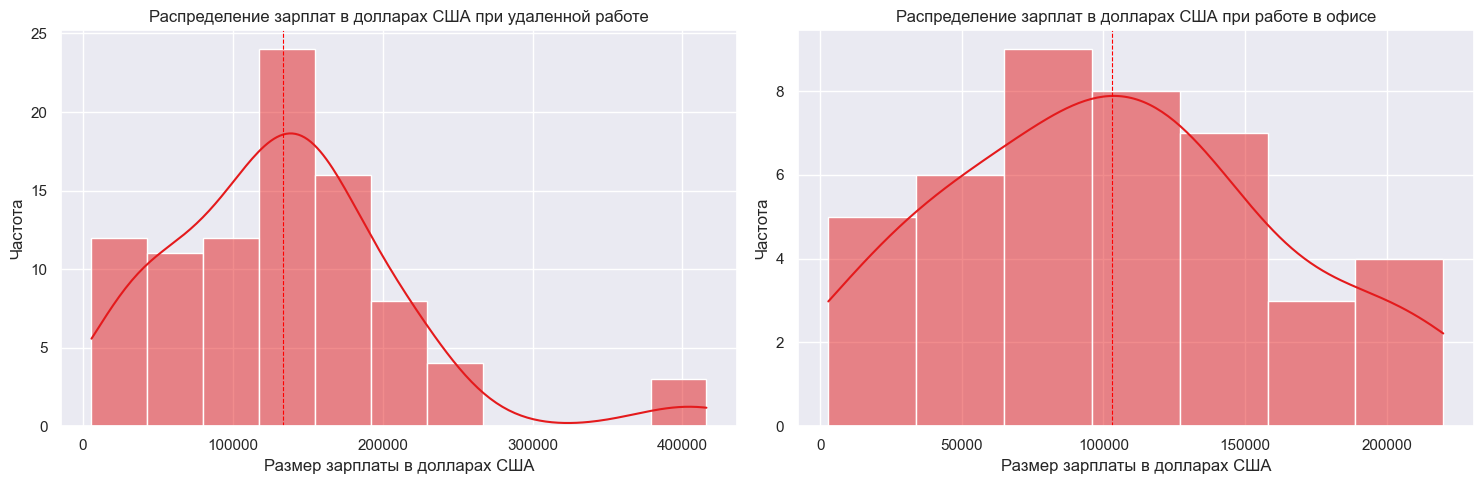


Статистики для удаленной работы:
count        90.00
mean     133584.96
std       78194.48
min        5679.00
25%       80625.00
50%      137485.00
75%      166555.00
max      416000.00
Name: salary_in_usd, dtype: float64

Статистики для работы в офисе:
count        42.00
mean     103008.24
std       59126.31
min        2859.00
25%       54850.25
50%      101050.00
75%      140400.00
max      220000.00
Name: salary_in_usd, dtype: float64


In [67]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма для удаленной работы
sns.histplot(remote_data, kde=True, ax=axes[0])  # убрали ['salary_in_usd']
axes[0].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплат в долларах США при удаленной работе')
axes[0].axvline(remote_data.mean(), color='red', linestyle='--', linewidth=0.8)

# Гистограмма для офисной работы
sns.histplot(office_data, kde=True, ax=axes[1])  # убрали ['salary_in_usd']
axes[1].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[1].set_title('Распределение зарплат в долларах США при работе в офисе')
axes[1].axvline(office_data.mean(), color='red', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# Выводим основные статистики
print("\nСтатистики для удаленной работы:")
print(remote_data.describe().round(2))
print("\nСтатистики для работы в офисе:")
print(office_data.describe().round(2))

Размер зарплат у специалистов Data Scientist — это количественный признак.

Групп две, они независимы. 

Признак не распределён по нормальному закону в одной из групп 

В этом случае также можно использовать U-критерий Манна — Уитни.

In [68]:
# проводим тест U-критерий Манна — Уитни
_, p = stats.mannwhitneyu(remote_data, office_data, alternative = 'greater')
print('Проверяем нулевую гипотезы m1 <= m2:')
decision_hypothesis(p)

Проверяем нулевую гипотезы m1 <= m2:
p-value = 0.015
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Выводы по дополнительной Бизнес-гипотезы 4.1

Есть статистически значимые доказательств того, что зарплата специалистов Data Science при удаленной работе больше зарплаты при работе в офисе.

***

### 4.2 Дополнительная Бизнес-гипотеза: 

Бизнес-гипотеза A: 

В крупных компаниях (company_size = 'L') зарплата Data Science Senior (SE) меньше, чем в малых компаниях (company_size = 'S')

Бизнес-гипотеза B: 

В крупных компаниях (company_size = 'L') зарплата Data Science junior (EN) меньше, чем в малых компаниях (company_size = 'S')


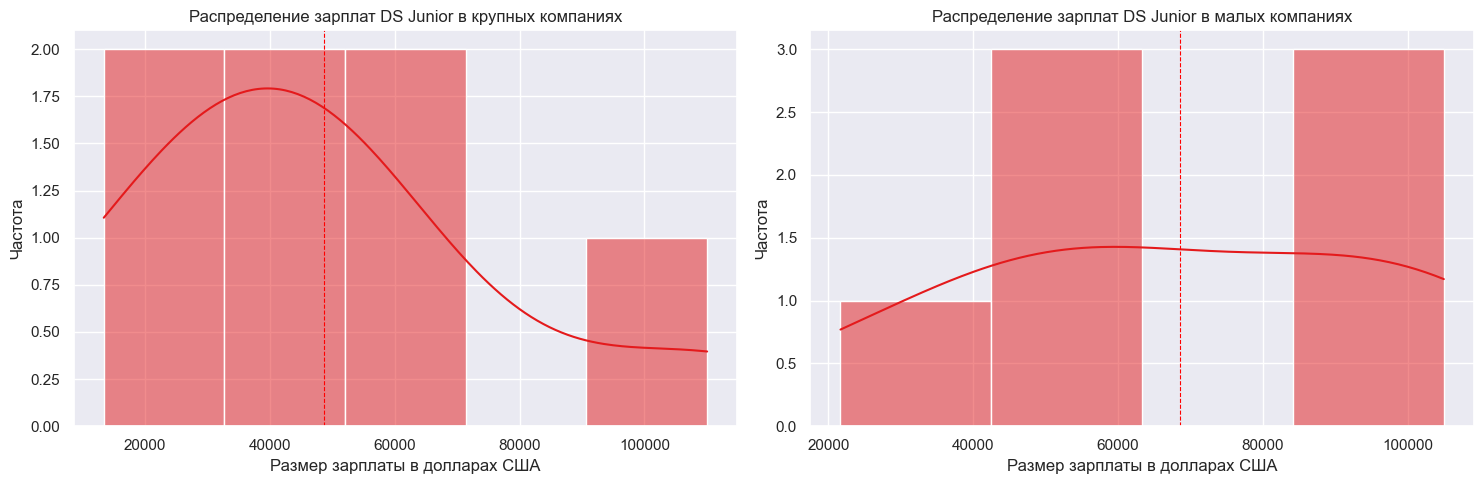


Статистики для зарплат DS Junior в крупных компаниях:
count         7.00
mean      48603.86
std       30791.04
min       13400.00
25%       33197.00
50%       40000.00
75%       55198.00
max      110037.00
Name: salary_in_usd, dtype: float64

Статистики для зарплат DS Junior в малых компаниях:
count         7.00
mean      68569.14
std       30763.04
min       21669.00
25%       50294.50
50%       62726.00
75%       95000.00
max      105000.00
Name: salary_in_usd, dtype: float64


In [ ]:
# Создаем выборки для сравнения:
large_junior = ds_data[(ds_data['company_size'] == 'L') & 
                      (ds_data['experience_level'] == 'EN')]['salary_in_usd']
large_senior = ds_data[(ds_data['company_size'] == 'L') & 
                      (ds_data['experience_level'] == 'SE')]['salary_in_usd']
small_junior = ds_data[(ds_data['company_size'] == 'S') & 
                      (ds_data['experience_level'] == 'EN')]['salary_in_usd']
small_senior = ds_data[(ds_data['company_size'] == 'S') & 
                      (ds_data['experience_level'] == 'SE')]['salary_in_usd']

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма для удаленной работы
sns.histplot(large_junior, kde=True, ax=axes[0])  # убрали ['salary_in_usd']
axes[0].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплат DS Junior в крупных компаниях')
axes[0].axvline(large_junior.mean(), color='red', linestyle='--', linewidth=0.8)

# Гистограмма для офисной работы
sns.histplot(small_junior, kde=True, ax=axes[1])  # убрали ['salary_in_usd']
axes[1].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[1].set_title('Распределение зарплат DS Junior в малых компаниях')
axes[1].axvline(small_junior.mean(), color='red', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# Выводим основные статистики
print("\nСтатистики для зарплат DS Junior в крупных компаниях:")
print(large_junior.describe().round(2))
print("\nСтатистики для зарплат DS Junior в малых компаниях:")
print(small_junior.describe().round(2))

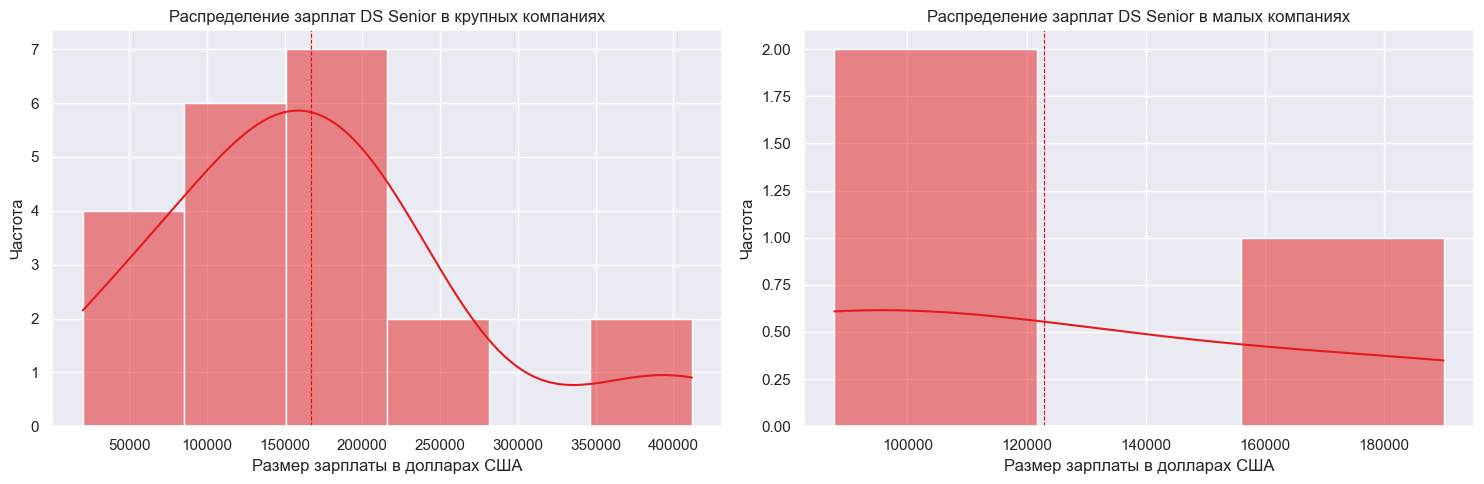


Статистики для зарплат DS Senior в крупных компаниях:
count        21.00
mean     166902.48
std       97567.17
min       20171.00
25%      120000.00
50%      158200.00
75%      215300.00
max      412000.00
Name: salary_in_usd, dtype: float64

Статистики для зарплат DS Senior в малых компаниях:
count         3.00
mean     122991.67
std       58057.28
min       87738.00
25%       89487.50
50%       91237.00
75%      140618.50
max      190000.00
Name: salary_in_usd, dtype: float64


In [71]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма для удаленной работы
sns.histplot(large_senior, kde=True, ax=axes[0])  # убрали ['salary_in_usd']
axes[0].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплат DS Senior в крупных компаниях')
axes[0].axvline(large_senior.mean(), color='red', linestyle='--', linewidth=0.8)

# Гистограмма для офисной работы
sns.histplot(small_senior, kde=True, ax=axes[1])  # убрали ['salary_in_usd']
axes[1].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[1].set_title('Распределение зарплат DS Senior в малых компаниях')
axes[1].axvline(small_senior.mean(), color='red', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

# Выводим основные статистики
print("\nСтатистики для зарплат DS Senior в крупных компаниях:")
print(large_senior.describe().round(2))
print("\nСтатистики для зарплат DS Senior в малых компаниях:")
print(small_senior.describe().round(2))

In [73]:
# Проверяем на нормальность
_, p = stats.shapiro(large_junior)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Junior в крупных компаниях:')
decision_normality(p)

_, p = stats.shapiro(small_junior)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Junior в малых компаниях:')
decision_normality(p)

_, p = stats.shapiro(large_senior)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Senior в крупных компаниях:')
decision_normality(p)

_, p = stats.shapiro(small_senior)
print('Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Senior в малых компаниях:')
decision_normality(p)

Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Junior в крупных компаниях:
p-value = 0.255
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Junior в малых компаниях:
p-value = 0.570
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Senior в крупных компаниях:
p-value = 0.071
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Проверка нормальности по тесту Шапиро — Уилка для показателя salary_in_usd для зарплат DS Senior в малых компаниях:
p-value = 0.058
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [86]:
# проводим тест Левена на равенство дисперсий для senior
print('Тест на равенство дисперсий для senior')
result = stats.levene(large_senior, small_senior)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий для senior
p-value = 0.393
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [85]:
# проводим тест Левена на равенство дисперсий для junior
print('Тест на равенство дисперсий для junior')
result = stats.levene(large_junior, small_junior)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий для junior
p-value = 0.683
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


Для проверки Бизнес-гипотез математически сформулируем статистические гипотезы.

Размер зарплат у специалистов Data Scientist — это количественный признак.
Групп две, они независимы. 
Признак распределён по нормальному закону 

В этом случае можно использовать Двухвыборочный t-критерий (t-test), чтобы сравнить средние значения в двух независимых группах.


А. Статистические гипотезы:


Нулевая гипотеза: В крупных компаниях зарплата Data Science Senior ($\mu_1$) больше или равна, чем в малых компаниях ($\mu_2$).

$$ H_0 : \mu_1 \geq \mu_2 $$


Альтернативная гипотеза: В крупных компаниях зарплата Data Science Senior ($\mu_1$) меньше, чем в малых компаниях ($\mu_2$).

$$ H_1 : \mu_1 < \mu_2 $$



In [82]:
# проводим тест на сравнение средних в группах
print('\nТест на сравнение средних зарплат Data Science Senior в крупных и малых компаниях')
_, p = stats.ttest_ind(large_senior, small_senior, alternative='less', equal_var=True)
decision_hypothesis(p)



Тест на сравнение средних зарплат Data Science Senior в крупных и малых компаниях
p-value = 0.770
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

Зарплата Data Science Senior в крупных компаниях больше или равна, чем в малых компаниях.

B. Статистические гипотезы:


Нулевая гипотеза: В крупных компаниях зарплата Data Science Junior ($\mu_3$) больше или равна, чем в малых компаниях ($\mu_4$).

$$ H_0 : \mu_3 \geq \mu_4 $$


Альтернативная гипотеза: В крупных компаниях зарплата Data Science Junior ($\mu_3$) меньше, чем в малых компаниях ($\mu_4$).

$$ H_1 : \mu_3 < \mu_4 $$

In [84]:
# проводим тест на сравнение средних в группах
print('\nТест на сравнение средних зарплат Data Science Junior в крупных и малых компаниях')
_, p = stats.ttest_ind(large_junior, small_junior, alternative='less', equal_var=True)
decision_hypothesis(p)


Тест на сравнение средних зарплат Data Science Junior в крупных и малых компаниях
p-value = 0.124
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

Зарплата Data Science Junior в крупных компаниях больше или равна, чем в малых компаниях.

### Выводы по дополнительной Бизнес-гипотезе 4.2:

Есть статистически значимые доказательств того, что :
- Зарплата Data Science Senior в крупных компаниях больше или равна, чем в малых компаниях.
- Зарплата Data Science Junior в крупных компаниях больше или равна, чем в малых компаниях 